In [25]:
import psycopg2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Conectar ao banco
conn = psycopg2.connect(
    dbname="mimiciv",
    user="desafio_mimic",
    password="desafio_mimic",
    host="localhost",
    port="5432"
)


📊 Resumo de Mortalidade com Classificação Técnica:
   obito_uti  obito_hosp  obito_1ano  sobreviventes  obitos_totais  \
0       7710        1996        9639          46021          19345   

   total_pacientes  
0            65366  


/tmp/ipykernel_185560/751421308.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_resultado = pd.read_sql(query_resultado, conn)
/tmp/ipykernel_185560/751421308.py:89: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(
/tmp/ipykernel_185560/751421308.py:89: UserWarning: The palette list has more values (10) than needed (5), which may not be intended.
  barplot = sns.barplot(


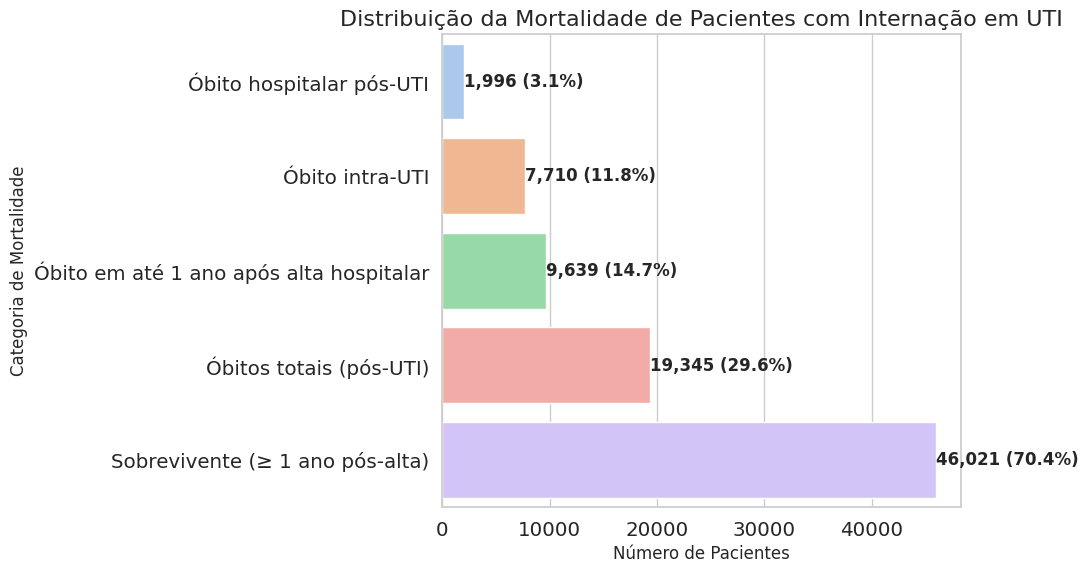

In [26]:
cursor = conn.cursor()

# SQL com mortalidade exclusiva baseada na última UTI, salvando como pacientes_mortos
sql_script = """
-- Última internação na UTI por paciente
CREATE TEMP TABLE ultima_uti AS
SELECT *
FROM (
    SELECT 
        i.subject_id,
        i.hadm_id,
        i.stay_id,
        i.intime,
        i.outtime,
        p.dod,
        a.admittime,
        a.dischtime,
        a.hospital_expire_flag,
        ROW_NUMBER() OVER (PARTITION BY i.subject_id ORDER BY i.outtime DESC) AS rn
    FROM mimiciv_icu.icustays i
    JOIN mimiciv_hosp.admissions a ON i.hadm_id = a.hadm_id
    JOIN mimiciv_hosp.patients p ON i.subject_id = p.subject_id
) t
WHERE rn = 1;

-- Tabela final com classificação exclusiva e nome técnico
CREATE TEMP TABLE pacientes_mortos AS
SELECT
  subject_id,
  stay_id,
  CASE
    WHEN dod IS NOT NULL AND dod <= outtime THEN 'Óbito intra-UTI'
    WHEN dod IS NOT NULL AND dod > outtime AND dod <= dischtime THEN 'Óbito hospitalar pós-UTI'
    WHEN dod IS NOT NULL AND dod > dischtime AND dod <= dischtime + INTERVAL '1 year' THEN 'Óbito em até 1 ano após alta hospitalar'
    ELSE 'Sobrevivente (≥ 1 ano pós-alta)'
  END AS categoria
FROM ultima_uti;
"""

# Executar SQL
cursor.execute("ROLLBACK")
cursor.execute(sql_script)
conn.commit()

# Consulta dos dados agregados
query_resultado = """
SELECT
  COUNT(*) FILTER (WHERE categoria = 'Óbito intra-UTI') AS obito_uti,
  COUNT(*) FILTER (WHERE categoria = 'Óbito hospitalar pós-UTI') AS obito_hosp,
  COUNT(*) FILTER (WHERE categoria = 'Óbito em até 1 ano após alta hospitalar') AS obito_1ano,
  COUNT(*) FILTER (WHERE categoria = 'Sobrevivente (≥ 1 ano pós-alta)') AS sobreviventes,
  COUNT(*) FILTER (WHERE categoria != 'Sobrevivente (≥ 1 ano pós-alta)') AS obitos_totais,
  COUNT(*) AS total_pacientes
FROM pacientes_mortos;
"""

df_resultado = pd.read_sql(query_resultado, conn)

# Exibir os dados
print("\n📊 Resumo de Mortalidade com Classificação Técnica:")
print(df_resultado)

# Montar dados para o gráfico
dados = {
    'Categoria de Mortalidade': [
        'Óbito intra-UTI',
        'Óbito hospitalar pós-UTI',
        'Óbito em até 1 ano após alta hospitalar',
        'Óbitos totais (pós-UTI)',
        'Sobrevivente (≥ 1 ano pós-alta)'
    ],
    'Quantidade': [
        df_resultado['obito_uti'][0],
        df_resultado['obito_hosp'][0],
        df_resultado['obito_1ano'][0],
        df_resultado['obitos_totais'][0],
        df_resultado['sobreviventes'][0]
    ]
}

df_plot = pd.DataFrame(dados)
df_plot['Porcentagem (%)'] = df_plot['Quantidade'] / df_resultado['total_pacientes'][0] * 100

# Estética
sns.set(style="whitegrid", font_scale=1.3)
cores = sns.color_palette("pastel")

plt.figure(figsize=(11, 6))
barplot = sns.barplot(
    data=df_plot.sort_values('Quantidade', ascending=True), 
    x='Quantidade', y='Categoria de Mortalidade', palette=cores
)

# Texto nas barras
for i, (qtd, pct) in enumerate(zip(df_plot.sort_values('Quantidade', ascending=True)['Quantidade'],
                                   df_plot.sort_values('Quantidade', ascending=True)['Porcentagem (%)'])):
    barplot.text(qtd + 20, i, f'{qtd:,} ({pct:.1f}%)', va='center', fontsize=12, fontweight='bold')

plt.title("Distribuição da Mortalidade de Pacientes com Internação em UTI", fontsize=16)
plt.xlabel("Número de Pacientes", fontsize=12)
plt.ylabel("Categoria de Mortalidade", fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipykernel_185560/936717665.py:12: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_mortes = pd.read_sql_query(query_mortes, conn)
/tmp/ipykernel_185560/936717665.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=genero_counts.index, y=genero_percent.values, palette=cores, edgecolor='black')
/tmp/ipykernel_185560/936717665.py:25: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.barplot(x=genero_counts.index, y=genero_percent.values, palette=cores, edgecolor='black')



📊 Gênero dos pacientes que morreram:
gender
M    10543
F     8802
Name: count, dtype: int64

📊 Idade (anchor_age) dos pacientes que morreram - Estatísticas:
count    19345.000000
mean        69.960868
std         14.774356
min         18.000000
25%         60.000000
50%         72.000000
75%         82.000000
max         91.000000
Name: anchor_age, dtype: float64


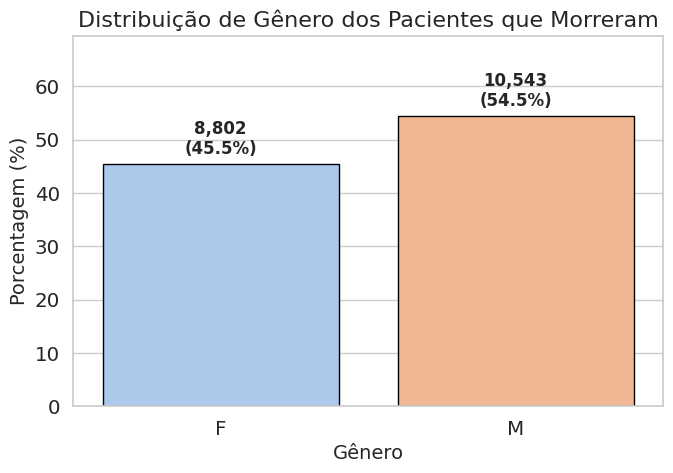

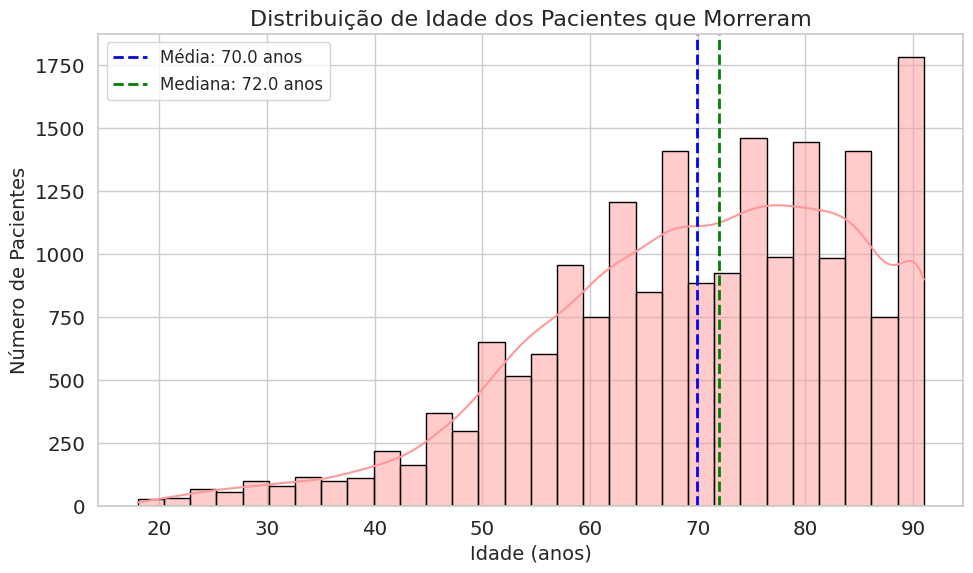

In [27]:
query_mortes = """
SELECT DISTINCT
    p.subject_id,
    p.gender,
    p.anchor_age
FROM mimiciv_hosp.patients p
JOIN pacientes_mortos pm 
  ON p.subject_id = pm.subject_id
  WHERE pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)';
"""

df_mortes = pd.read_sql_query(query_mortes, conn)

# Análise descritiva
print("\n📊 Gênero dos pacientes que morreram:")
print(df_mortes['gender'].value_counts())
print("\n📊 Idade (anchor_age) dos pacientes que morreram - Estatísticas:")
print(df_mortes['anchor_age'].describe())

# Gráfico: gênero
genero_counts = df_mortes['gender'].value_counts().sort_index()
genero_percent = genero_counts / genero_counts.sum() * 100

plt.figure(figsize=(7,5))
sns.barplot(x=genero_counts.index, y=genero_percent.values, palette=cores, edgecolor='black')
for i, (count, pct) in enumerate(zip(genero_counts.values, genero_percent.values)):
    plt.text(i, pct + 1, f'{count:,}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.title("Distribuição de Gênero dos Pacientes que Morreram", fontsize=16)
plt.xlabel("Gênero", fontsize=14)
plt.ylabel("Porcentagem (%)", fontsize=14)
plt.ylim(0, genero_percent.max() + 15)
plt.tight_layout()
plt.show()

# Gráfico: idade
plt.figure(figsize=(10,6))
sns.histplot(df_mortes['anchor_age'], bins=30, kde=True, color="#FF9999", edgecolor='black')
media = df_mortes['anchor_age'].mean()
mediana = df_mortes['anchor_age'].median()
plt.axvline(media, color='blue', linestyle='--', linewidth=2, label=f'Média: {media:.1f} anos')
plt.axvline(mediana, color='green', linestyle='--', linewidth=2, label=f'Mediana: {mediana:.1f} anos')
plt.title("Distribuição de Idade dos Pacientes que Morreram", fontsize=16)
plt.xlabel("Idade (anos)", fontsize=14)
plt.ylabel("Número de Pacientes", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()


📊 Número de Admissões na ICU e Mortalidade:
  faixa_admissoes_icu  total_pacientes  total_mortes  taxa_mortalidade
0                   1            49124         12234         24.904324
1                 >10              141            98         69.503546
2                   2            10341          3984         38.526255
3                 3-5             5076          2609         51.398739
4                6-10              684           420         61.403509


/tmp/ipykernel_185560/2767895719.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_admissoes_icu_mortalidade = pd.read_sql_query(query_admissoes_icu_mortalidade, conn)
/tmp/ipykernel_185560/2767895719.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_admissoes_icu_mortalidade, x="faixa_admissoes_icu", y="taxa_mortalidade", palette="coolwarm", edgecolor="black")


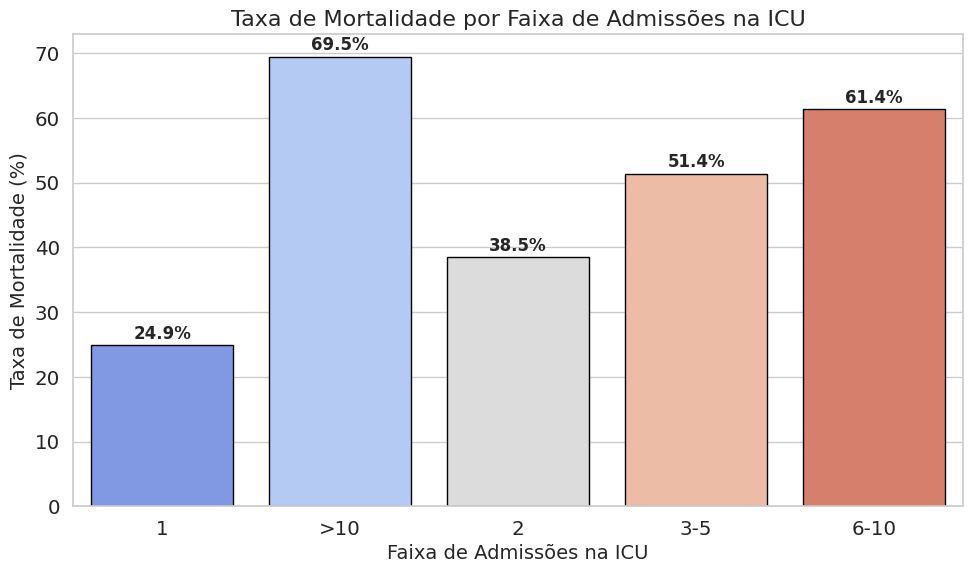

/tmp/ipykernel_185560/2767895719.py:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_admissoes_icu_mortalidade, x="faixa_admissoes_icu", y="total_pacientes", palette="viridis", edgecolor="black")


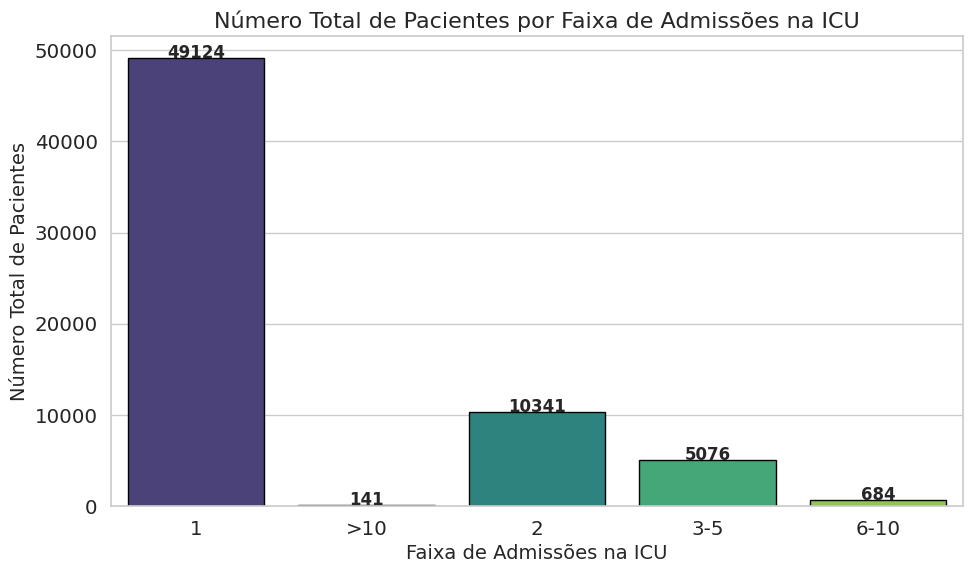

In [28]:
# Consulta SQL para obter o número de admissões na ICU e a mortalidade de todos os pacientes
query_admissoes_icu_mortalidade = """
WITH admissoes_icu_por_paciente AS (
    SELECT 
        p.subject_id,
        COUNT(i.stay_id) AS num_admissoes_icu,
        MAX(CASE WHEN pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 1 ELSE 0 END) AS morreu
    FROM mimiciv_icu.icustays i
    JOIN mimiciv_hosp.patients p ON i.subject_id = p.subject_id
    LEFT JOIN pacientes_mortos pm ON p.subject_id = pm.subject_id
    GROUP BY p.subject_id
)
SELECT 
    CASE 
        WHEN num_admissoes_icu = 1 THEN '1'
        WHEN num_admissoes_icu = 2 THEN '2'
        WHEN num_admissoes_icu BETWEEN 3 AND 5 THEN '3-5'
        WHEN num_admissoes_icu BETWEEN 6 AND 10 THEN '6-10'
        ELSE '>10'
    END AS faixa_admissoes_icu,
    COUNT(*) AS total_pacientes,
    SUM(morreu) AS total_mortes,
    (SUM(morreu)::float / COUNT(*)) * 100 AS taxa_mortalidade
FROM admissoes_icu_por_paciente
GROUP BY faixa_admissoes_icu
ORDER BY faixa_admissoes_icu;
"""

# Carregar os resultados da consulta SQL em um DataFrame
df_admissoes_icu_mortalidade = pd.read_sql_query(query_admissoes_icu_mortalidade, conn)

# Exibir os resultados no console
print("\n📊 Número de Admissões na ICU e Mortalidade:")
print(df_admissoes_icu_mortalidade)

# Gráfico: Faixa de admissões na ICU vs Taxa de mortalidade
plt.figure(figsize=(10, 6))
sns.barplot(data=df_admissoes_icu_mortalidade, x="faixa_admissoes_icu", y="taxa_mortalidade", palette="coolwarm", edgecolor="black")
plt.title("Taxa de Mortalidade por Faixa de Admissões na ICU", fontsize=16)
plt.xlabel("Faixa de Admissões na ICU", fontsize=14)
plt.ylabel("Taxa de Mortalidade (%)", fontsize=14)

# Adicionar valores nas barras
for i, row in df_admissoes_icu_mortalidade.iterrows():
    plt.text(i, row["taxa_mortalidade"] + 1, f"{row['taxa_mortalidade']:.1f}%", ha="center", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

# Gráfico: Faixa de admissões na ICU vs Total de pacientes
plt.figure(figsize=(10, 6))
sns.barplot(data=df_admissoes_icu_mortalidade, x="faixa_admissoes_icu", y="total_pacientes", palette="viridis", edgecolor="black")
plt.title("Número Total de Pacientes por Faixa de Admissões na ICU", fontsize=16)
plt.xlabel("Faixa de Admissões na ICU", fontsize=14)
plt.ylabel("Número Total de Pacientes", fontsize=14)

# Adicionar valores nas barras
for i, row in df_admissoes_icu_mortalidade.iterrows():
    plt.text(i, row["total_pacientes"] + 1, f"{int(row['total_pacientes'])}", ha="center", fontsize=12, fontweight="bold")

plt.tight_layout()
plt.show()

/tmp/ipykernel_185560/1489693499.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tempo_permanencia = pd.read_sql(query_tempo_permanencia_icu, conn)
/tmp/ipykernel_185560/1489693499.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_tempo_permanencia, x="mortalidade", y="tempo_permanencia_dias", palette="coolwarm")



📊 Estatísticas Descritivas do Tempo de Permanência na ICU (em dias) por Mortalidade:
                    count      mean       std       min       25%       50%  \
mortalidade                                                                   
Não Sobrevivente  33920.0  4.383000  6.383982  0.001447  1.158056  2.255584   
Sobrevivente      60524.0  3.208028  4.712537  0.001250  1.076085  1.841354   

                       75%         max  
mortalidade                             
Não Sobrevivente  4.861684  226.403079  
Sobrevivente      3.338961  159.666806  


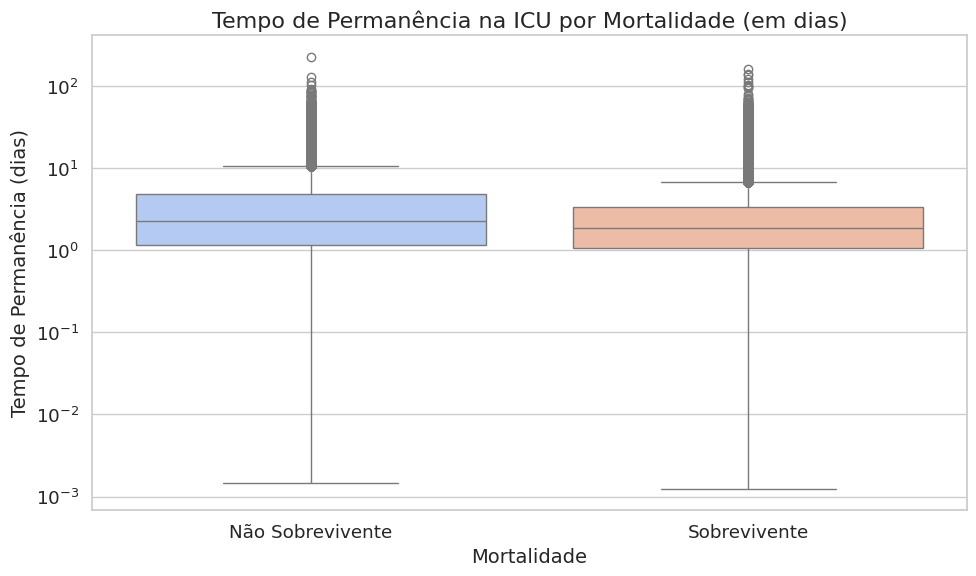

In [41]:
# Consulta SQL para obter o tempo de permanência na ICU e a mortalidade
query_tempo_permanencia_icu = """
WITH tempo_permanencia AS (
    SELECT 
        i.subject_id,
        i.stay_id,
        EXTRACT(EPOCH FROM (i.outtime - i.intime)) / 3600 AS tempo_permanencia_horas,
        CASE 
            WHEN pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 'Não Sobrevivente'
            ELSE 'Sobrevivente'
        END AS mortalidade
    FROM mimiciv_icu.icustays i
    LEFT JOIN pacientes_mortos pm ON i.subject_id = pm.subject_id
    WHERE i.outtime IS NOT NULL AND i.intime IS NOT NULL
)
SELECT 
    mortalidade,
    tempo_permanencia_horas
FROM tempo_permanencia;
"""

# Executar a consulta SQL e carregar os dados no DataFrame
df_tempo_permanencia = pd.read_sql(query_tempo_permanencia_icu, conn)

# Ajustar o tempo de permanência de horas para dias
df_tempo_permanencia['tempo_permanencia_dias'] = df_tempo_permanencia['tempo_permanencia_horas'] / 24

# Exibir estatísticas descritivas com o tempo em dias
print("\n📊 Estatísticas Descritivas do Tempo de Permanência na ICU (em dias) por Mortalidade:")
print(df_tempo_permanencia.groupby("mortalidade")["tempo_permanencia_dias"].describe())

# Criar o boxplot com o tempo em dias
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_tempo_permanencia, x="mortalidade", y="tempo_permanencia_dias", palette="coolwarm")

# Configurar o título e os rótulos
plt.title("Tempo de Permanência na ICU por Mortalidade (em dias)", fontsize=16)
plt.xlabel("Mortalidade", fontsize=14)
plt.ylabel("Tempo de Permanência (dias)", fontsize=14)

# Adicionar escala logarítmica no eixo Y (opcional, se houver outliers extremos)
plt.yscale("log")

# Melhorar o layout
plt.tight_layout()
plt.show()


📊 Taxa de Mortalidade por Faixa Etária:
faixa_etaria
0-18       0.000000
19-30      0.280535
31-40      0.864108
41-50      2.335244
51-60      5.067023
61-70      8.295682
71-80     12.631831
81-90     17.073361
91-100    17.963292
dtype: float64


/tmp/ipykernel_185560/3817738694.py:16: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_total_pacientes = pd.read_sql_query(query_total_pacientes, conn)
/tmp/ipykernel_185560/3817738694.py:22: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_por_faixa = df_total_pacientes.groupby('faixa_etaria')['total_pacientes'].sum()
/tmp/ipykernel_185560/3817738694.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=taxa_mortalidade.index, y=taxa_mortalidade.values, palette="Reds", edgecolor='black')


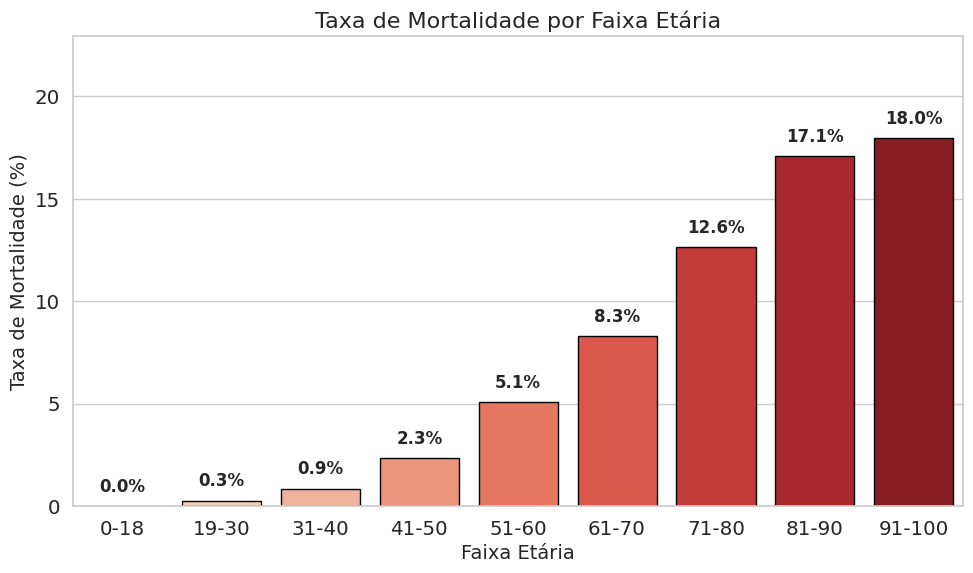

In [30]:
# Definir faixas etárias
bins = [0, 18, 30, 40, 50, 60, 70, 80, 90, 100]
labels = ['0-18', '19-30', '31-40', '41-50', '51-60', '61-70', '71-80', '81-90', '91-100']

# Adicionar coluna de faixa etária ao DataFrame de pacientes mortos
df_mortes['faixa_etaria'] = pd.cut(df_mortes['anchor_age'], bins=bins, labels=labels, right=False)

# Consultar o total de pacientes (vivos e mortos) por faixa etária
query_total_pacientes = """
SELECT 
    anchor_age,
    COUNT(*) AS total_pacientes
FROM mimiciv_hosp.patients
GROUP BY anchor_age;
"""
df_total_pacientes = pd.read_sql_query(query_total_pacientes, conn)

# Adicionar coluna de faixa etária ao DataFrame total
df_total_pacientes['faixa_etaria'] = pd.cut(df_total_pacientes['anchor_age'], bins=bins, labels=labels, right=False)

# Calcular o total de pacientes por faixa etária
total_por_faixa = df_total_pacientes.groupby('faixa_etaria')['total_pacientes'].sum()

# Calcular o total de mortes por faixa etária
mortes_por_faixa = df_mortes['faixa_etaria'].value_counts().sort_index()

# Calcular a taxa de mortalidade por faixa etária
taxa_mortalidade = (mortes_por_faixa / total_por_faixa * 100).fillna(0)

# Exibir os resultados
print("\n📊 Taxa de Mortalidade por Faixa Etária:")
print(taxa_mortalidade)

# Gráfico: Taxa de Mortalidade por Faixa Etária
plt.figure(figsize=(10,6))
sns.barplot(x=taxa_mortalidade.index, y=taxa_mortalidade.values, palette="Reds", edgecolor='black')
for i, pct in enumerate(taxa_mortalidade.values):
    plt.text(i, pct + 0.5, f'{pct:.1f}%', ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.title("Taxa de Mortalidade por Faixa Etária", fontsize=16)
plt.xlabel("Faixa Etária", fontsize=14)
plt.ylabel("Taxa de Mortalidade (%)", fontsize=14)
plt.ylim(0, taxa_mortalidade.max() + 5)
plt.tight_layout()
plt.show()

/tmp/ipykernel_185560/4091857818.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_diag = pd.read_sql(query_diag_top20_mortos, conn)


📁 CSV salvo: diagnósticos_pacientes_mortos_traduzidos.csv


/tmp/ipykernel_185560/4091857818.py:83: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


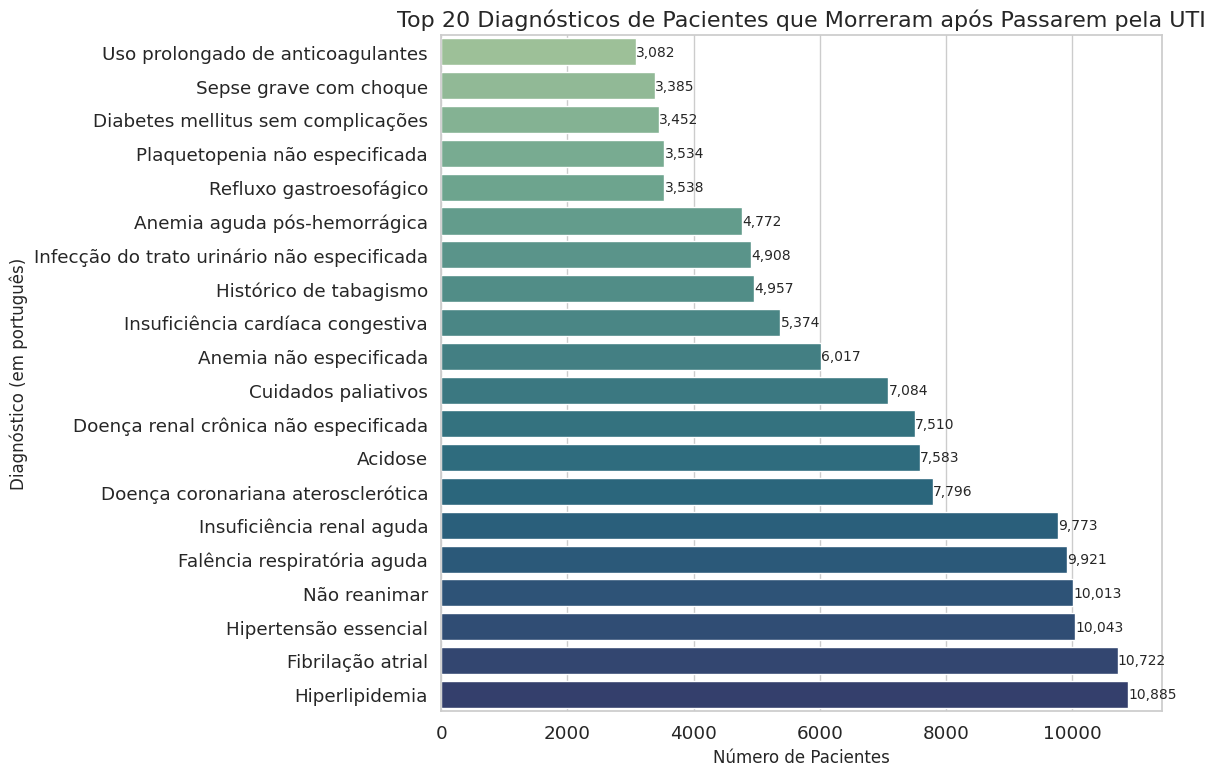

In [31]:
query_diag_top20_mortos = """
SELECT 
    d.icd_code,
    di.long_title AS diagnosis,
    COUNT(*) AS freq
FROM mimiciv_hosp.diagnoses_icd d
JOIN mimiciv_hosp.d_icd_diagnoses di 
    ON d.icd_code = di.icd_code
JOIN (
    SELECT DISTINCT subject_id, hadm_id
    FROM mimiciv_icu.icustays
) AS icu
    ON d.subject_id = icu.subject_id AND d.hadm_id = icu.hadm_id
JOIN pacientes_mortos pm
    ON d.subject_id = pm.subject_id
WHERE pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)'
GROUP BY d.icd_code, di.long_title
ORDER BY freq DESC;
"""

df_diag = pd.read_sql(query_diag_top20_mortos, conn)

# Dicionário atualizado com traduções
grupos_diagnosticos = {
    "Hipertensão essencial": ["Unspecified essential hypertension", "Essential (primary) hypertension"],
    "Insuficiência cardíaca congestiva": ["Congestive heart failure, unspecified"],
    "Fibrilação atrial": ["Atrial fibrillation"],
    "Insuficiência renal aguda": ["Acute kidney failure, unspecified", "N179", "5849"],
    "Hiperlipidemia": ["Hyperlipidemia, unspecified", "Other and unspecified hyperlipidemia"],
    "Cuidados paliativos": ["Encounter for palliative care"],
    "Não reanimar": ["Do not resuscitate", "Do not resuscitate status"],
    "Histórico de tabagismo": ["Personal history of nicotine dependence"],
    "Acidose": ["Acidosis"],
    "Doença coronariana aterosclerótica": [
        "Atherosclerotic heart disease of native coronary artery",
        "Coronary atherosclerosis of native coronary artery"
    ],
    "Falência respiratória aguda": [
        "Acute respiratory failure", 
        "Acute respiratory failure with hypoxia"
    ],
    "Sepse grave com choque": ["Severe sepsis with septic shock"],
    "Refluxo gastroesofágico": ["Gastro-esophageal reflux disease without esophagitis"],
    "Diabetes mellitus sem complicações": ["Diabetes mellitus without mention of complication"],
    "Plaquetopenia não especificada": ["Thrombocytopenia, unspecified"],
    "Doença renal crônica não especificada": ["Chronic kidney disease, unspecified"],
    "Infecção do trato urinário não especificada": ["Urinary tract infection, site not specified"],
    "Anemia aguda pós-hemorrágica": ["Acute posthemorrhagic anemia"],
    "Anemia não especificada": ["Anemia, unspecified"],
    "Uso prolongado de anticoagulantes": ["Long term (current) use of anticoagulants"],
    "Refluxo Esofágico": ["Esophageal reflux"]
}

def traduzir_ou_agrupar(row):
    for grupo, termos in grupos_diagnosticos.items():
        for termo in termos:
            if termo.lower() in row['diagnosis'].lower():
                return grupo
    return row['diagnosis']  # mantém o nome original, mesmo que esteja em inglês

# Aplicar agrupamento
df_diag['diagnostico_pt'] = df_diag.apply(traduzir_ou_agrupar, axis=1)

# Agrupar final
df_diag_agrupado = (
    df_diag.groupby('diagnostico_pt')
           .agg({
               'freq': 'sum',
               'icd_code': lambda x: ', '.join(sorted(set(x)))
           })
           .reset_index()
           .sort_values('freq', ascending=False)
           .head(20)
)

# Salvar CSV com nomes traduzidos
df_diag_agrupado.to_csv("diagnosticos_pacientes_mortos_traduzidos.csv", index=False)
print("📁 CSV salvo: diagnósticos_pacientes_mortos_traduzidos.csv")

# GRÁFICO com nomes traduzidos
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_diag_agrupado.sort_values('freq', ascending=True),
    x='freq',
    y='diagnostico_pt',
    palette='crest'
)

plt.title("Top 20 Diagnósticos de Pacientes que Morreram após Passarem pela UTI", fontsize=16)
plt.xlabel("Número de Pacientes", fontsize=12)
plt.ylabel("Diagnóstico (em português)", fontsize=12)

for i, (value, label) in enumerate(zip(df_diag_agrupado.sort_values('freq', ascending=True)['freq'],
                                       df_diag_agrupado.sort_values('freq', ascending=True)['diagnostico_pt'])):
    plt.text(value + 5, i, f"{value:,}", va='center', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_185560/3321618262.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_comorbidades = pd.read_sql_query(query_comorbidades_mortalidade, conn)



📊 Top 20 Comorbidades que Mais Mataram e Suas Taxas de Mortalidade:
                        diagnostico_pt   freq  mortes  taxa_mortalidade
0                         Não reanimar   8277    6738         81.406307
1                       Hiperlipidemia  18998    6150         32.371829
2                Hipertensão essencial  17457    5779         33.104199
3    Insuficiência cardíaca congestiva  10232    5374         52.521501
4                  Cuidados paliativos   5477    5267         96.165784
5            Insuficiência renal aguda  11223    5224         46.547269
6                    Fibrilação atrial  10932    5049         46.185510
7               Histórico de tabagismo  13522    4957         36.658778
8                       Hiperlipidemia  13414    4735         35.298941
9            Insuficiência renal aguda   8799    4549         51.699057
10         Falência respiratória aguda   8595    4443         51.692845
11                             Acidose   8308    4287         51.60

/tmp/ipykernel_185560/3321618262.py:43: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


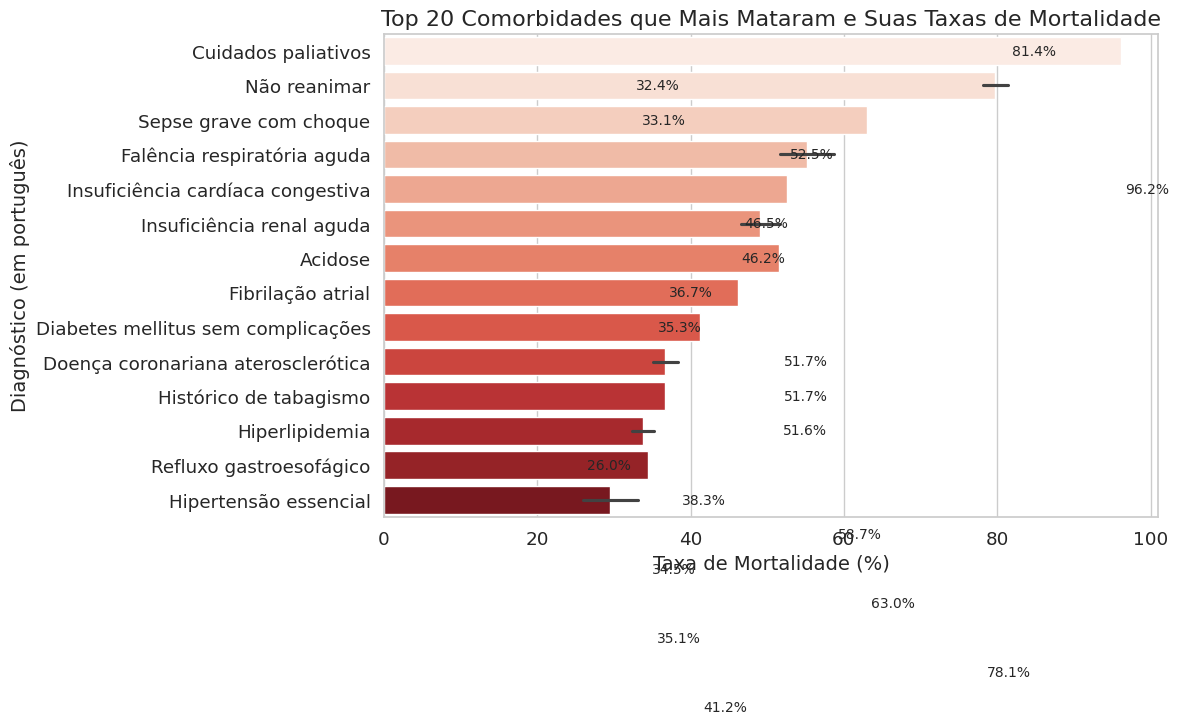

In [32]:
# Consulta SQL para obter as comorbidades e calcular as taxas de mortalidade
query_comorbidades_mortalidade = """
WITH comorbidades AS (
    SELECT 
        d.icd_code,
        di.long_title AS diagnosis,
        COUNT(*) AS freq,
        SUM(CASE WHEN pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 1 ELSE 0 END) AS mortes
    FROM mimiciv_hosp.diagnoses_icd d
    JOIN mimiciv_hosp.d_icd_diagnoses di 
        ON d.icd_code = di.icd_code
    JOIN (
        SELECT DISTINCT subject_id, hadm_id
        FROM mimiciv_icu.icustays
    ) AS icu
        ON d.subject_id = icu.subject_id AND d.hadm_id = icu.hadm_id
    LEFT JOIN pacientes_mortos pm
        ON d.subject_id = pm.subject_id
    GROUP BY d.icd_code, di.long_title
)
SELECT 
    diagnosis,
    freq,
    mortes,
    (mortes::float / freq) * 100 AS taxa_mortalidade
FROM comorbidades
ORDER BY mortes DESC
LIMIT 20;
"""

# Carregar os resultados da consulta SQL em um DataFrame
df_comorbidades = pd.read_sql_query(query_comorbidades_mortalidade, conn)

# Traduzir os diagnósticos para português usando o dicionário
df_comorbidades['diagnostico_pt'] = df_comorbidades['diagnosis'].apply(lambda x: traduzir_ou_agrupar({'diagnosis': x}))

# Exibir os resultados no console
print("\n📊 Top 20 Comorbidades que Mais Mataram e Suas Taxas de Mortalidade:")
print(df_comorbidades[['diagnostico_pt', 'freq', 'mortes', 'taxa_mortalidade']])

# Gráfico: Top 20 comorbidades e suas taxas de mortalidade
plt.figure(figsize=(12, 8))
sns.barplot(
    data=df_comorbidades.sort_values('taxa_mortalidade', ascending=False),
    x='taxa_mortalidade',
    y='diagnostico_pt',
    palette='Reds'
)

plt.title("Top 20 Comorbidades que Mais Mataram e Suas Taxas de Mortalidade", fontsize=16)
plt.xlabel("Taxa de Mortalidade (%)", fontsize=14)
plt.ylabel("Diagnóstico (em português)", fontsize=14)

# Adicionar valores nas barras
for i, (value, label) in enumerate(zip(df_comorbidades['taxa_mortalidade'], df_comorbidades['diagnostico_pt'])):
    plt.text(value + 0.5, i, f"{value:.1f}%", va='center', fontsize=10)

plt.tight_layout()
plt.show()

/tmp/ipykernel_185560/147451574.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_diag_comorb = pd.read_sql(query_diag_comorb_mortos, conn)


📁 CSV salvo como: diagnósticos_charlson_mortos_traduzidos.csv


/tmp/ipykernel_185560/147451574.py:91: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


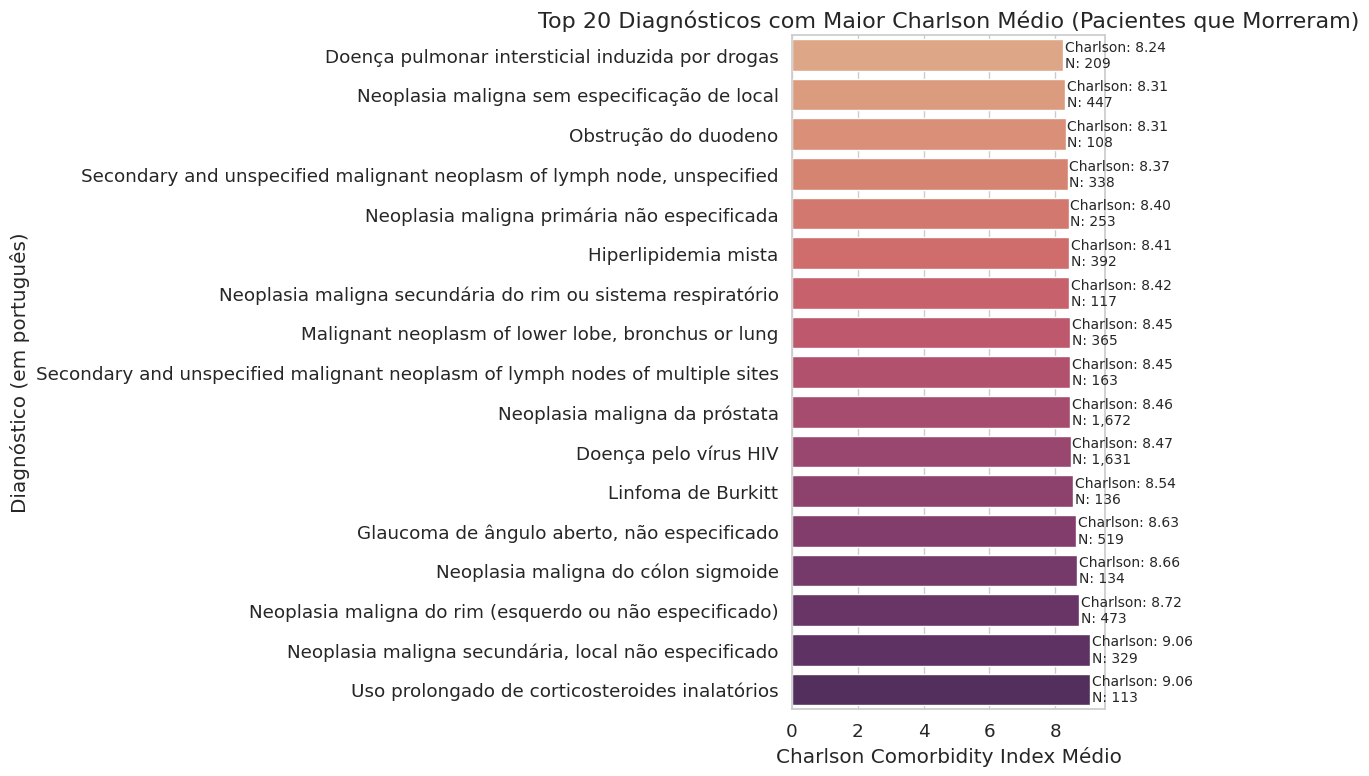

/tmp/ipykernel_185560/147451574.py:123: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_charlson = pd.read_sql(query_charlson_categorias, conn)
/tmp/ipykernel_185560/147451574.py:142: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(
/tmp/ipykernel_185560/147451574.py:142: UserWarning: The palette list has more values (8) than needed (4), which may not be intended.
  ax = sns.boxplot(


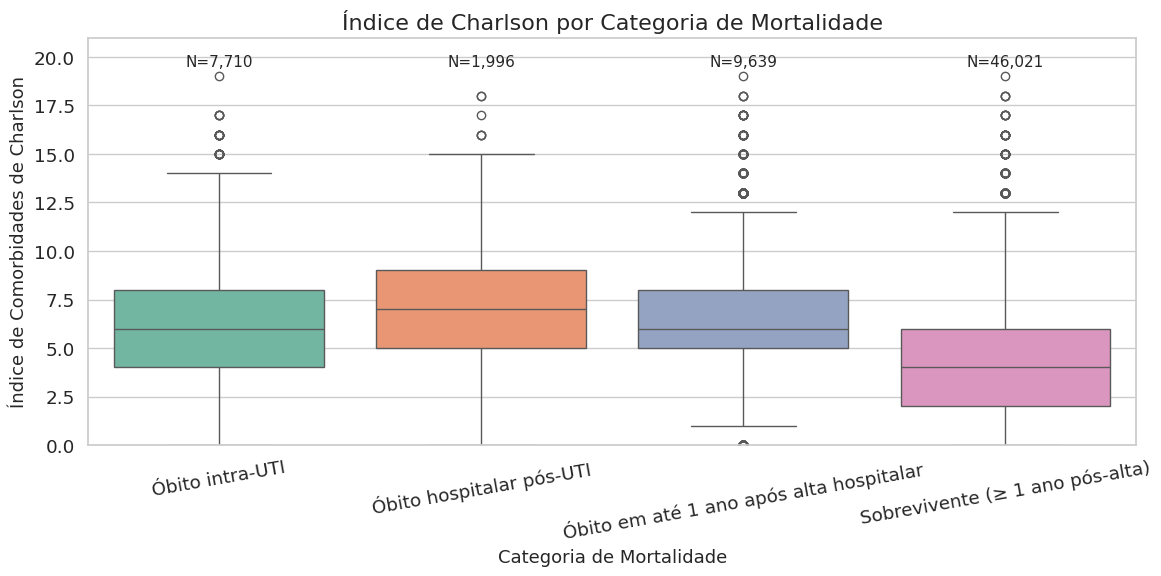

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 🔎 Consulta SQL: diagnósticos + Charlson entre pacientes que morreram
query_diag_comorb_mortos = """
SELECT 
    d.icd_code,
    di.long_title AS diagnosis,
    AVG(c.charlson_comorbidity_index) AS media_charlson,
    COUNT(*) AS freq
FROM mimiciv_hosp.diagnoses_icd d
JOIN mimiciv_hosp.d_icd_diagnoses di 
  ON d.icd_code = di.icd_code
JOIN mimiciv_derived.charlson c
  ON d.subject_id = c.subject_id
JOIN (
    SELECT DISTINCT subject_id, hadm_id
    FROM mimiciv_icu.icustays
) AS icu
  ON d.subject_id = icu.subject_id AND d.hadm_id = icu.hadm_id
JOIN pacientes_mortos pm
  ON d.subject_id = pm.subject_id
WHERE pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)'
GROUP BY d.icd_code, di.long_title
HAVING COUNT(*) >= 100
ORDER BY media_charlson DESC
LIMIT 20;
"""

# Carregar resultado
df_diag_comorb = pd.read_sql(query_diag_comorb_mortos, conn)

# 🧠 Dicionário expandido com novas traduções
grupos_diagnosticos.update({
    "Uso prolongado de corticosteroides inalatórios": ["Long term (current) use of inhaled steroids"],
    "Neoplasia maligna secundária, local não especificado": ["Secondary malignant neoplasm of unspecified site"],
    "Glaucoma de ângulo aberto, não especificado": ["Open-angle glaucoma, unspecified", "Unspecified open-angle glaucoma, stage unspecified"],
    "Neoplasia maligna do cólon sigmoide": ["Malignant neoplasm of sigmoid colon"],
    "Neoplasia maligna do rim (esquerdo ou não especificado)": [
        "Malignant neoplasm of left kidney, except renal pelvis",
        "Malignant neoplasm of unspecified kidney, except renal pelvis"
    ],
    "Neoplasia maligna da próstata": ["Malignant neoplasm of prostate"],
    "Hiperlipidemia mista": ["Mixed hyperlipidemia"],
    "Obstrução do duodeno": ["Obstruction of duodenum"],
    "Doença pelo vírus HIV": ["Human immunodeficiency virus [HIV] disease"],
    "Linfoma de Burkitt": ["Burkitt's tumor or lymphoma, unspecified site, extranodal and solid organ sites"],
    "Neoplasia maligna primária não especificada": ["Malignant (primary) neoplasm, unspecified"],
    "Neoplasia maligna sem especificação de local": ["Other malignant neoplasm without specification of site"],
    "Neoplasia maligna secundária do rim ou sistema respiratório": [
        "Secondary and unspecified malignant neoplasm of respiratory system",
        "Secondary malignant neoplasm of unspecified kidney and renal pelvis"
    ],
    "Doença pulmonar intersticial induzida por drogas": ["Drug-induced interstitial lung disorders, unspecified"]
})

# Traduzir diagnósticos
def traduzir_ou_agrupar(row):
    for grupo, termos in grupos_diagnosticos.items():
        for termo in termos:
            if termo.lower() in row['diagnosis'].lower():
                return grupo
    return row['diagnosis']  # fallback

df_diag_comorb['diagnostico_pt'] = df_diag_comorb.apply(traduzir_ou_agrupar, axis=1)

# Agrupar diagnósticos traduzidos
df_diag_comorb_agrupado = (
    df_diag_comorb.groupby('diagnostico_pt')
                  .agg({
                      'media_charlson': 'mean',
                      'freq': 'sum',
                      'icd_code': lambda x: ', '.join(sorted(set(x)))
                  })
                  .reset_index()
                  .sort_values('media_charlson', ascending=False)
                  .head(20)
)

# Salvar CSV
df_diag_comorb_agrupado.to_csv("diagnosticos_charlson_mortos_traduzidos.csv", index=False)
print("📁 CSV salvo como: diagnósticos_charlson_mortos_traduzidos.csv")

# 📊 Gráfico com valores corretos anotados nas barras
sns.set(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(12, 8))

df_plot = df_diag_comorb_agrupado.sort_values('media_charlson', ascending=True)

ax = sns.barplot(
    data=df_plot,
    x='media_charlson',
    y='diagnostico_pt',
    palette='flare'
)

# Corrigir as anotações usando as barras reais
for bar, (_, row) in zip(ax.patches, df_plot.iterrows()):
    ax.text(
        bar.get_width() + 0.05,
        bar.get_y() + bar.get_height() / 2,
        f"Charlson: {row['media_charlson']:.2f}\nN: {row['freq']:,}",
        va='center',
        fontsize=10
    )

plt.title("Top 20 Diagnósticos com Maior Charlson Médio (Pacientes que Morreram)", fontsize=16)
plt.xlabel("Charlson Comorbidity Index Médio")
plt.ylabel("Diagnóstico (em português)")
plt.tight_layout()
plt.show()

query_charlson_categorias = """
SELECT 
    c.subject_id,
    pm.categoria,
    c.charlson_comorbidity_index
FROM mimiciv_derived.charlson c
JOIN pacientes_mortos pm ON c.subject_id = pm.subject_id;
"""

df_charlson = pd.read_sql(query_charlson_categorias, conn)

# ✅ Remover duplicados por segurança (1 paciente = 1 linha)
df_charlson = df_charlson.drop_duplicates(subset='subject_id')

# 📌 Definir ordem lógica das categorias
ordem_categoria = [
    'Óbito intra-UTI',
    'Óbito hospitalar pós-UTI',
    'Óbito em até 1 ano após alta hospitalar',
    'Sobrevivente (≥ 1 ano pós-alta)'
]

# 🎨 Estilo
sns.set(style="whitegrid", font_scale=1.2)
cores = sns.color_palette("Set2")

# 📊 Gráfico 1 — Boxplot por categoria de mortalidade
plt.figure(figsize=(12,6))
ax = sns.boxplot(
    data=df_charlson,
    x='categoria',
    y='charlson_comorbidity_index',
    order=ordem_categoria,
    palette=cores
)

# 🔢 Contar N reais por grupo
counts = df_charlson['categoria'].value_counts()

# 🧾 Anotar Ns corretos acima das barras
for i, cat in enumerate(ordem_categoria):
    n = counts.get(cat, 0)
    ax.text(i, df_charlson['charlson_comorbidity_index'].max() + 0.5,
            f"N={n:,}", ha='center', fontsize=11)

plt.title("Índice de Charlson por Categoria de Mortalidade", fontsize=16)
plt.xlabel("Categoria de Mortalidade", fontsize=13)
plt.ylabel("Índice de Comorbidades de Charlson", fontsize=13)
plt.xticks(rotation=10)
plt.ylim(0, df_charlson['charlson_comorbidity_index'].max() + 2)
plt.tight_layout()
plt.show()

/tmp/ipykernel_185560/3190667516.py:57: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vaso_morte = pd.read_sql(sql_query, conn)


/tmp/ipykernel_185560/3190667516.py:85: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_vaso_morte, y="droga_pt", x="n", palette="coolwarm_r")



📊 Pacientes que usaram vasopressores e morreram:
        droga_pt     n
4  Noradrenalina  6457
5    Fenilefrina  3399
6   Vasopressina  3225
2     Epinefrina  1341
1       Dopamina   967
0     Dobutamina   605
3      Milrinona   292


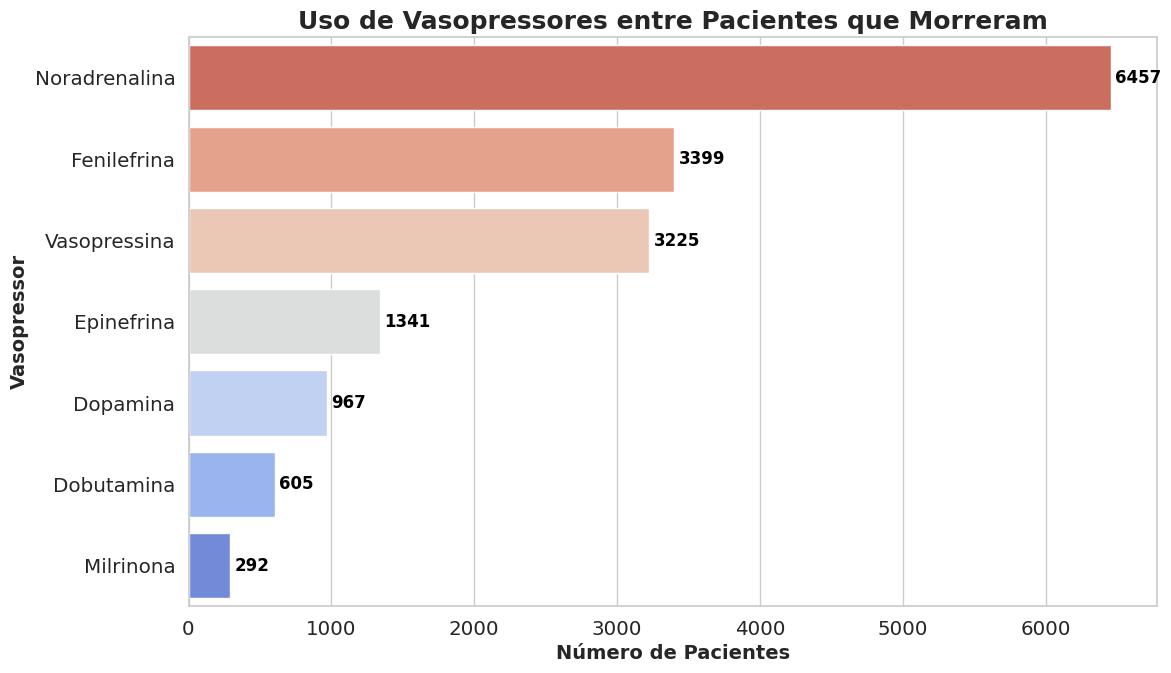

In [34]:
sql_query = """
WITH vaso_flag AS (
    SELECT
        v.stay_id,
        MAX(CASE WHEN v.dopamine IS NOT NULL THEN 1 ELSE 0 END) AS dopamine,
        MAX(CASE WHEN v.epinephrine IS NOT NULL THEN 1 ELSE 0 END) AS epinephrine,
        MAX(CASE WHEN v.norepinephrine IS NOT NULL THEN 1 ELSE 0 END) AS norepinephrine,
        MAX(CASE WHEN v.phenylephrine IS NOT NULL THEN 1 ELSE 0 END) AS phenylephrine,
        MAX(CASE WHEN v.dobutamine IS NOT NULL THEN 1 ELSE 0 END) AS dobutamine,
        MAX(CASE WHEN v.milrinone IS NOT NULL THEN 1 ELSE 0 END) AS milrinone
    FROM mimiciv_derived.vasoactive_agent v
    GROUP BY v.stay_id
),
vasopressin_flag AS (
    SELECT DISTINCT stay_id, 1 AS vasopressin
    FROM mimiciv_derived.vasopressin
)
SELECT 
    'dopamine' AS droga, COUNT(*) AS n
FROM vaso_flag vf
JOIN pacientes_mortos pm ON vf.stay_id = pm.stay_id
WHERE vf.dopamine = 1 AND pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)'
UNION
SELECT 
    'epinephrine', COUNT(*) FROM vaso_flag vf 
JOIN pacientes_mortos pm ON vf.stay_id = pm.stay_id
WHERE vf.epinephrine = 1 AND pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)'
UNION
SELECT 
    'norepinephrine', COUNT(*) FROM vaso_flag vf 
JOIN pacientes_mortos pm ON vf.stay_id = pm.stay_id
WHERE vf.norepinephrine = 1 AND pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)'
UNION
SELECT 
    'phenylephrine', COUNT(*) FROM vaso_flag vf 
JOIN pacientes_mortos pm ON vf.stay_id = pm.stay_id
WHERE vf.phenylephrine = 1 AND pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)'
UNION
SELECT 
    'dobutamine', COUNT(*) FROM vaso_flag vf 
JOIN pacientes_mortos pm ON vf.stay_id = pm.stay_id
WHERE vf.dobutamine = 1 AND pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)'
UNION
SELECT 
    'milrinone', COUNT(*) FROM vaso_flag vf 
JOIN pacientes_mortos pm ON vf.stay_id = pm.stay_id
WHERE vf.milrinone = 1 AND pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)'
UNION
SELECT 
    'vasopressin', COUNT(*) 
FROM vasopressin_flag vp 
JOIN pacientes_mortos pm ON vp.stay_id = pm.stay_id
WHERE vp.vasopressin = 1 AND pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)';
"""

# Carregar os resultados em um DataFrame
df_vaso_morte = pd.read_sql(sql_query, conn)

# Ordenar os resultados pela quantidade (n)
df_vaso_morte = df_vaso_morte.sort_values("n", ascending=False)

# 🧠 Dicionário para traduzir os vasopressores
vasopressores_pt = {
    'dopamine': 'Dopamina',
    'epinephrine': 'Epinefrina',
    'norepinephrine': 'Noradrenalina',
    'phenylephrine': 'Fenilefrina',
    'dobutamine': 'Dobutamina',
    'milrinone': 'Milrinona',
    'vasopressin': 'Vasopressina'
}

# Substituir os nomes das drogas para português
df_vaso_morte['droga_pt'] = df_vaso_morte['droga'].map(vasopressores_pt)

# Exibir os resultados no console com as traduções em português
print("\n📊 Pacientes que usaram vasopressores e morreram:")
print(df_vaso_morte[['droga_pt', 'n']])

# 📊 Gráfico com valores corretos anotados nas barras
plt.figure(figsize=(12, 7))

# Usar uma paleta mais vibrante
sns.set(style="whitegrid", font_scale=1.3)
ax = sns.barplot(data=df_vaso_morte, y="droga_pt", x="n", palette="coolwarm_r")

# Título do gráfico
plt.title("Uso de Vasopressores entre Pacientes que Morreram", fontsize=18, fontweight='bold')

# Rótulos de eixos
plt.xlabel("Número de Pacientes", fontsize=14, fontweight='bold')
plt.ylabel("Vasopressor", fontsize=14, fontweight='bold')

# Anotar a quantidade de pacientes nas barras
for i, (drug, value) in enumerate(zip(df_vaso_morte["droga_pt"], df_vaso_morte["n"])):
    ax.text(value + 30, i, f"{value}", va='center', fontsize=12, fontweight='bold', color='black')

# Melhorar espaçamento e formato
plt.tight_layout()

# Mostrar o gráfico
plt.show()

/tmp/ipykernel_185560/93799998.py:40: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_uso_vasopressores = pd.read_sql(sql_query_uso_vasopressores, conn)



📊 Quantidade de Pacientes com e sem Vasopressores e suas Mortalidades:
               grupo  total_pacientes  total_mortes  taxa_mortalidade
0  Sem Vasopressores            45743         11445         25.020222
1  Com Vasopressores            19623          7900         40.258880


/tmp/ipykernel_185560/93799998.py:53: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_uso_vasopressores, x="grupo", y="taxa_mortalidade", palette="coolwarm", edgecolor='black')


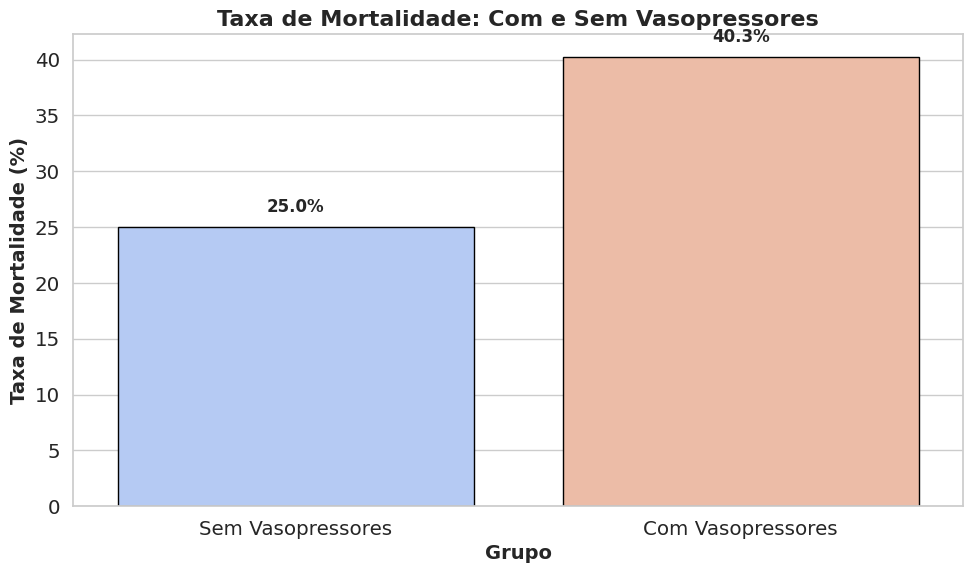

In [35]:
# Consulta SQL para obter dados de pacientes com e sem vasopressores
sql_query_uso_vasopressores = """
WITH vaso_flag AS (
    SELECT
        v.stay_id,
        MAX(CASE WHEN v.dopamine IS NOT NULL THEN 1 ELSE 0 END) AS dopamine,
        MAX(CASE WHEN v.epinephrine IS NOT NULL THEN 1 ELSE 0 END) AS epinephrine,
        MAX(CASE WHEN v.norepinephrine IS NOT NULL THEN 1 ELSE 0 END) AS norepinephrine,
        MAX(CASE WHEN v.phenylephrine IS NOT NULL THEN 1 ELSE 0 END) AS phenylephrine,
        MAX(CASE WHEN v.dobutamine IS NOT NULL THEN 1 ELSE 0 END) AS dobutamine,
        MAX(CASE WHEN v.milrinone IS NOT NULL THEN 1 ELSE 0 END) AS milrinone
    FROM mimiciv_derived.vasoactive_agent v
    GROUP BY v.stay_id
),
vasopressin_flag AS (
    SELECT DISTINCT stay_id, 1 AS vasopressin
    FROM mimiciv_derived.vasopressin
),
pacientes_com_vasopressores AS (
    SELECT DISTINCT stay_id
    FROM vaso_flag
    WHERE dopamine = 1 OR epinephrine = 1 OR norepinephrine = 1 OR phenylephrine = 1 
          OR dobutamine = 1 OR milrinone = 1
    UNION
    SELECT DISTINCT stay_id
    FROM vasopressin_flag
)
SELECT 
    CASE 
        WHEN pm.stay_id IN (SELECT stay_id FROM pacientes_com_vasopressores) THEN 'Com Vasopressores'
        ELSE 'Sem Vasopressores'
    END AS grupo,
    COUNT(*) AS total_pacientes,
    SUM(CASE WHEN pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 1 ELSE 0 END) AS total_mortes
FROM pacientes_mortos pm
GROUP BY grupo;
"""

# Carregar os resultados em um DataFrame
df_uso_vasopressores = pd.read_sql(sql_query_uso_vasopressores, conn)

# Calcular a taxa de mortalidade
df_uso_vasopressores['taxa_mortalidade'] = (df_uso_vasopressores['total_mortes'] / df_uso_vasopressores['total_pacientes']) * 100

# Exibir os resultados no console
print("\n📊 Quantidade de Pacientes com e sem Vasopressores e suas Mortalidades:")
print(df_uso_vasopressores)

# 📊 Gráfico de barras para visualização
plt.figure(figsize=(10, 6))

# Gráfico de barras
sns.barplot(data=df_uso_vasopressores, x="grupo", y="taxa_mortalidade", palette="coolwarm", edgecolor='black')

# Título e rótulos
plt.title("Taxa de Mortalidade: Com e Sem Vasopressores", fontsize=16, fontweight='bold')
plt.xlabel("Grupo", fontsize=14, fontweight='bold')
plt.ylabel("Taxa de Mortalidade (%)", fontsize=14, fontweight='bold')

# Anotar as taxas de mortalidade nas barras
for i, taxa in enumerate(df_uso_vasopressores['taxa_mortalidade']):
    plt.text(i, taxa + 1, f"{taxa:.1f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Melhorar espaçamento
plt.tight_layout()

# Mostrar o gráfico
plt.show()

/tmp/ipykernel_185560/166913906.py:18: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_ventilacao_mortalidade = pd.read_sql(query_ventilacao_mortalidade, conn)


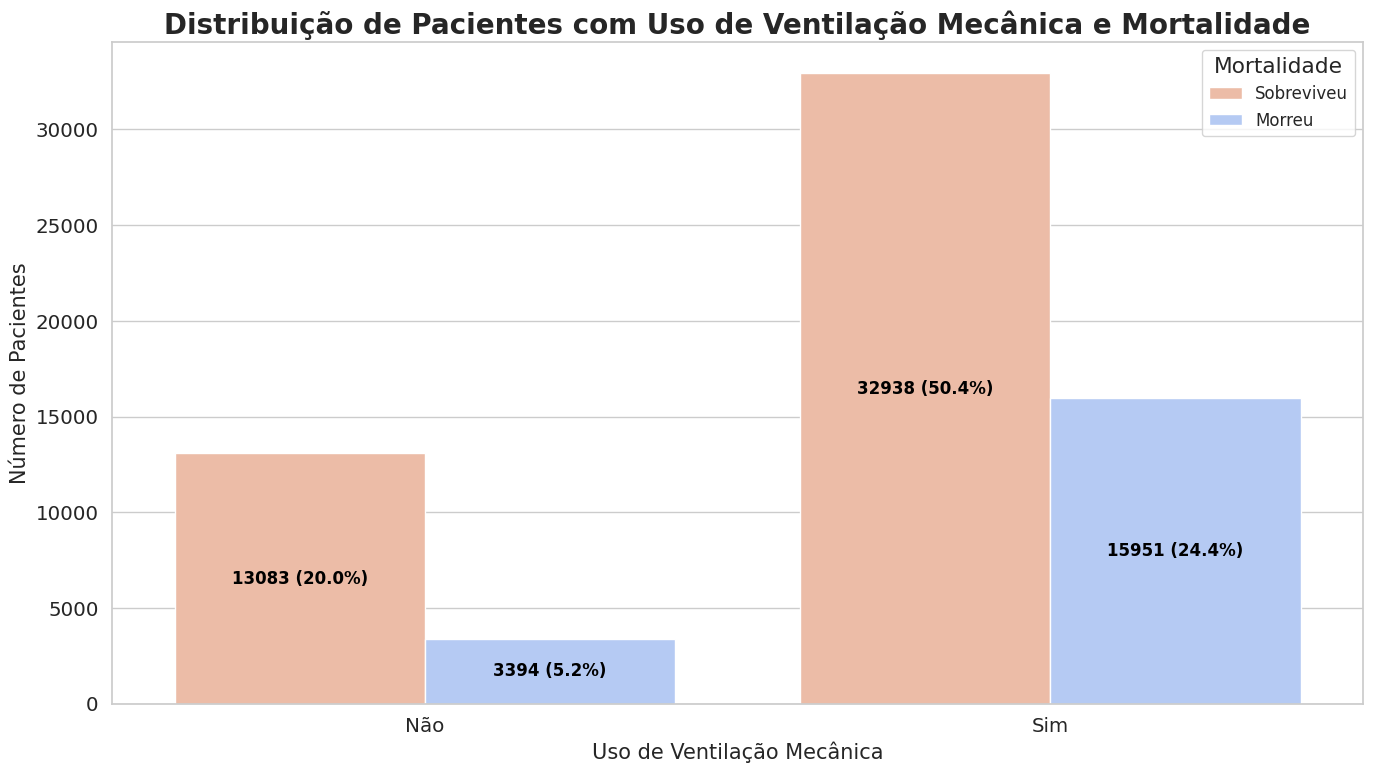

/tmp/ipykernel_185560/166913906.py:74: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tempo_vm = pd.read_sql(query_tempo_vm, conn)


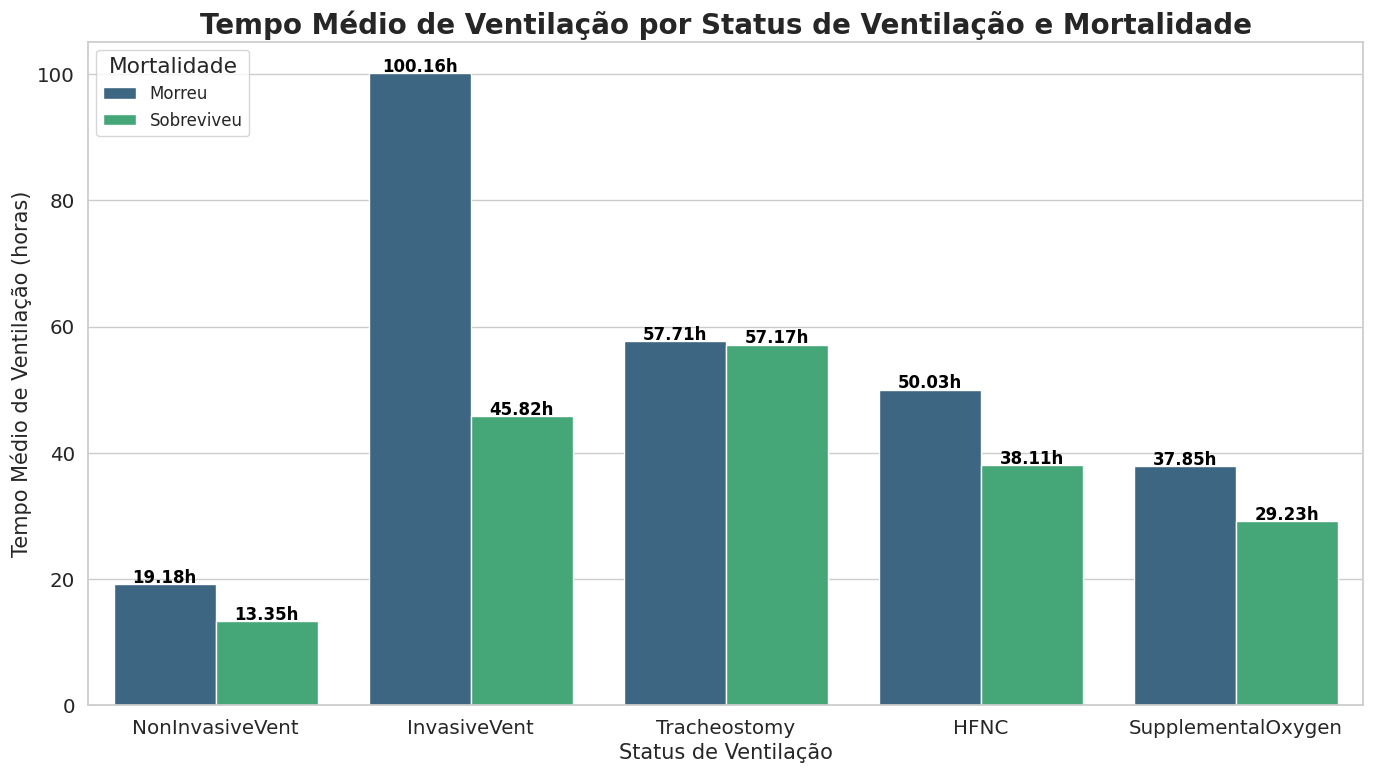

📊 Pacientes que usaram ventilação mecânica e morreram:
morreu
0    46021
1    19345
dtype: int64

📊 Tempo médio de ventilação por status de ventilação e mortalidade:
   ventilation_status  n_pacientes  media_horas grupo_mortalidade
0     NonInvasiveVent          666    19.184960            Morreu
1        InvasiveVent        15990    45.819443        Sobreviveu
2        InvasiveVent         8865   100.158291            Morreu
3        Tracheostomy          817    57.167931        Sobreviveu
4                HFNC         1006    50.030053            Morreu
5  SupplementalOxygen        10800    37.850100            Morreu
6        Tracheostomy          480    57.712917            Morreu
7     NonInvasiveVent         1077    13.351408        Sobreviveu
8  SupplementalOxygen        29982    29.226035        Sobreviveu
9                HFNC         1165    38.106066        Sobreviveu


In [36]:
# 🔎 Query para flag de ventilação mecânica e mortalidade na UTI
query_ventilacao_mortalidade = """
WITH ventilacao_mec AS (
    SELECT DISTINCT stay_id, 1 AS usou_vm
    FROM mimiciv_derived.ventilation
    WHERE ventilation_status IN ('InvasiveVent', 'NonInvasiveVent', 'SupplementalOxygen', 'HFNC', 'Tracheostomy')
)
SELECT 
    p.stay_id,
    COALESCE(v.usou_vm, 0) AS usou_vm,
    CASE WHEN pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 1 ELSE 0 END AS morreu
FROM mimiciv_icu.icustays p
LEFT JOIN ventilacao_mec v ON p.stay_id = v.stay_id
JOIN pacientes_mortos pm ON p.stay_id = pm.stay_id;
"""

# Carregar resultado
df_ventilacao_mortalidade = pd.read_sql(query_ventilacao_mortalidade, conn)

# 📊 Gráfico para ventilação mecânica vs mortalidade
plt.figure(figsize=(14, 8))
ax = sns.countplot(data=df_ventilacao_mortalidade, x='usou_vm', hue='morreu', palette='coolwarm_r')

# Melhorando título e labels
plt.title("Distribuição de Pacientes com Uso de Ventilação Mecânica e Mortalidade", fontsize=20, fontweight='bold')
plt.xlabel("Uso de Ventilação Mecânica", fontsize=15)
plt.ylabel("Número de Pacientes", fontsize=15)
plt.xticks([0, 1], ['Não', 'Sim'], rotation=0)
plt.legend(title='Mortalidade', loc='upper right', labels=['Sobreviveu', 'Morreu'], fontsize=12)

# Adicionar números e porcentagens nas barras
total_pacientes = len(df_ventilacao_mortalidade)
for p in ax.patches:
    height = p.get_height()
    width = p.get_width()
    if height > 0:  # Verifica se o valor é maior que zero
        x = p.get_x() + width / 2
        y = p.get_height() / 2
        percentage = height / total_pacientes * 100
        ax.text(x, y, f'{int(height)} ({percentage:.1f}%)', ha="center", va="center", fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

# 🔎 Query para calcular tempo total de ventilação (em horas) com relação à mortalidade
query_tempo_vm = """
WITH ventilacao_mec AS (
    SELECT 
        stay_id,
        ventilation_status,
        EXTRACT(EPOCH FROM (endtime - starttime))/3600.0 AS duracao_horas
    FROM mimiciv_derived.ventilation
    WHERE ventilation_status IN ('InvasiveVent', 'NonInvasiveVent', 'SupplementalOxygen', 'HFNC', 'Tracheostomy')
),
soma_por_paciente AS (
    SELECT 
        v.stay_id,
        v.ventilation_status,
        SUM(v.duracao_horas) AS tempo_total_horas
    FROM ventilacao_mec v
    GROUP BY v.stay_id, v.ventilation_status
)
SELECT 
    sp.ventilation_status,
    COUNT(*) AS n_pacientes,
    AVG(sp.tempo_total_horas) AS media_horas,
    CASE WHEN pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 'Morreu' ELSE 'Sobreviveu' END AS grupo_mortalidade
FROM soma_por_paciente sp
JOIN pacientes_mortos pm ON sp.stay_id = pm.stay_id
GROUP BY sp.ventilation_status, grupo_mortalidade;
"""

# Carregar resultado
df_tempo_vm = pd.read_sql(query_tempo_vm, conn)

# 📊 Gráfico para tempo total de ventilação por status de ventilação e mortalidade
plt.figure(figsize=(14, 8))
ax = sns.barplot(data=df_tempo_vm, x='ventilation_status', y='media_horas', hue='grupo_mortalidade', palette='viridis')

# Melhorando título e labels
plt.title("Tempo Médio de Ventilação por Status de Ventilação e Mortalidade", fontsize=20, fontweight='bold')
plt.xlabel("Status de Ventilação", fontsize=15)
plt.ylabel("Tempo Médio de Ventilação (horas)", fontsize=15)
plt.legend(title='Mortalidade', loc='upper left', fontsize=12)

# Adicionar valores nas barras somente se o valor for maior que zero
for p in ax.patches:
    height = p.get_height()
    if height > 0:  # Verifica se o valor é maior que zero
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        ax.text(x, y + 1, f'{y:.2f}h', ha="center", va="center", fontsize=12, fontweight='bold', color='black')

plt.tight_layout()
plt.show()

# Print dos resultados
print(f"📊 Pacientes que usaram ventilação mecânica e morreram:\n{df_ventilacao_mortalidade.groupby('morreu').size()}")
print(f"\n📊 Tempo médio de ventilação por status de ventilação e mortalidade:\n{df_tempo_vm}")

/tmp/ipykernel_185560/3551139475.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_vm_tempo = pd.read_sql(query_vm_tempo, conn)
/tmp/ipykernel_185560/3551139475.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_vm_tempo, x="mortalidade", y="tempo_vm_horas", palette="coolwarm", showfliers=False)


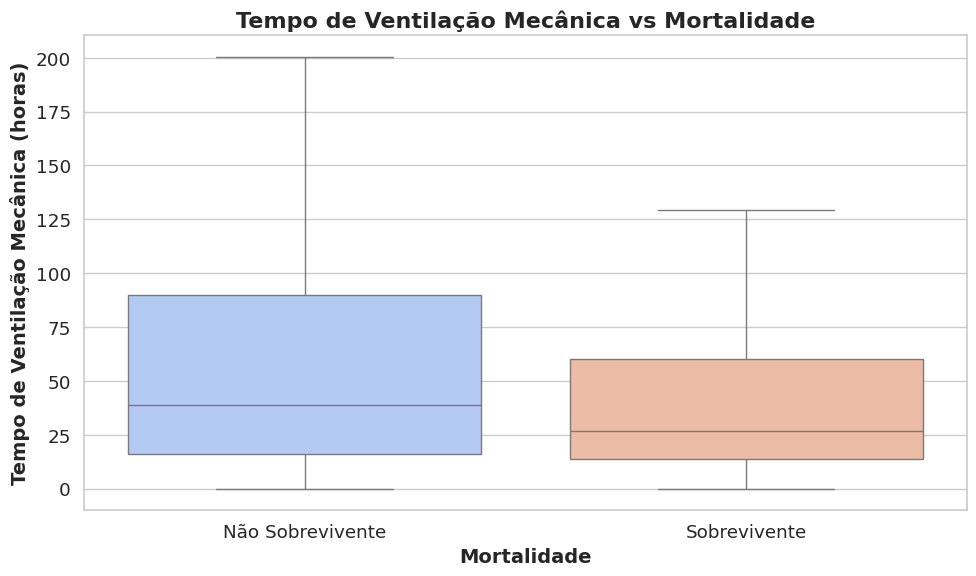

In [37]:
# 📥 Consulta SQL para obter o tempo de ventilação mecânica e mortalidade
query_vm_tempo = """
WITH ventilacao_tempo AS (
    SELECT 
        v.stay_id,
        i.subject_id,
        SUM(EXTRACT(EPOCH FROM (v.endtime - v.starttime)) / 3600) AS tempo_vm_horas
    FROM mimiciv_derived.ventilation v
    JOIN mimiciv_icu.icustays i ON v.stay_id = i.stay_id
    GROUP BY v.stay_id, i.subject_id
)
SELECT 
    vt.subject_id,
    vt.tempo_vm_horas,
    CASE 
        WHEN pm.categoria = 'Sobrevivente (≥ 1 ano pós-alta)' THEN 'Sobrevivente'
        ELSE 'Não Sobrevivente'
    END AS mortalidade
FROM ventilacao_tempo vt
JOIN pacientes_mortos pm ON vt.subject_id = pm.subject_id;
"""

# Carregar os resultados da consulta SQL em um DataFrame
df_vm_tempo = pd.read_sql(query_vm_tempo, conn)

# Substituir valores NaN (caso algum paciente não tenha tempo de ventilação registrado)
df_vm_tempo['tempo_vm_horas'] = df_vm_tempo['tempo_vm_horas'].fillna(0)

# 📊 Criar o gráfico de boxplot
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)

# Gráfico de boxplot
sns.boxplot(data=df_vm_tempo, x="mortalidade", y="tempo_vm_horas", palette="coolwarm", showfliers=False)

# Título e rótulos
plt.title("Tempo de Ventilação Mecânica vs Mortalidade", fontsize=16, fontweight='bold')
plt.xlabel("Mortalidade", fontsize=14, fontweight='bold')
plt.ylabel("Tempo de Ventilação Mecânica (horas)", fontsize=14, fontweight='bold')

# Melhorar espaçamento
plt.tight_layout()

# Mostrar o gráfico
plt.show()

/tmp/ipykernel_185560/3144030125.py:24: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rrt_mortalidade = pd.read_sql(query_rrt_mortalidade, conn)


📁 O arquivo foi salvo como: resultados_mortalidade_tsr.csv


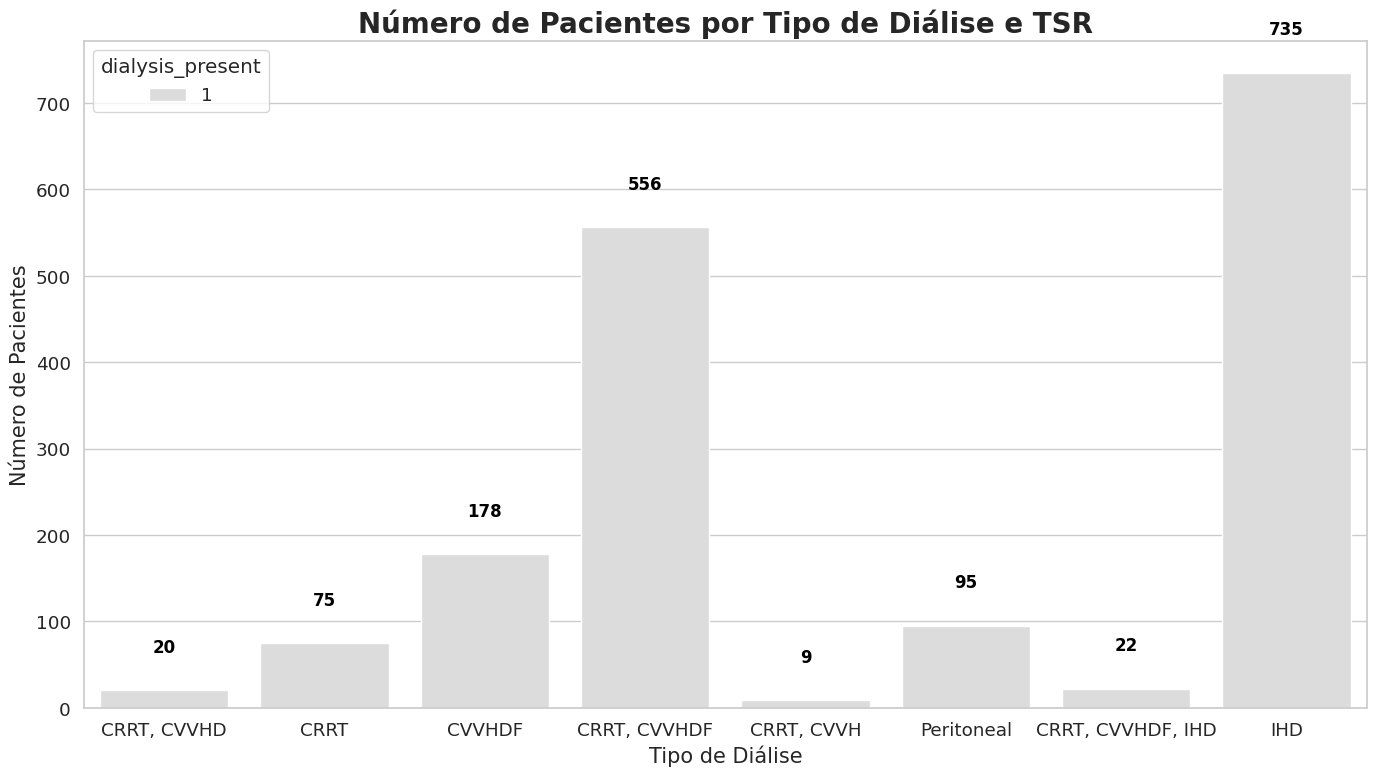


📊 Número Total de Pacientes e Mortalidade por Tipo de Diálise/TSR:
               dialysis_type  n_pacientes  n_mortes  porcentagem_morte
0                  CRRT, IHD            1         1         100.000000
1         CVVHDF, Peritoneal            1         1         100.000000
2            CRRT, CVVH, IHD            1         1         100.000000
3                CRRT, CVVHD           20        17          85.000000
4                       CRRT           75        59          78.666667
5                     CVVHDF          178       135          75.842697
6                CVVHDF, IHD            4         3          75.000000
7               CRRT, CVVHDF          556       411          73.920863
8                       CVVH            3         2          66.666667
9                 CRRT, CVVH            9         6          66.666667
10  CRRT, CVVHDF, Peritoneal            5         3          60.000000
11                Peritoneal           95        50          52.631579
12       

/tmp/ipykernel_185560/3144030125.py:92: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rrt_mortalidade = pd.read_sql(query_rrt_mortalidade, conn)


In [38]:
# Consultar e carregar os dados da query SQL ajustada para TSR e Mortalidade
query_rrt_mortalidade = """
WITH rrt_mortalidade AS (
    SELECT 
        r.dialysis_type,
        r.dialysis_present,
        COUNT(*) AS n_pacientes,  -- Contando todas as ocorrências de TSR
        COUNT(CASE WHEN pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 1 END) AS n_mortes
    FROM mimiciv_derived.first_day_rrt r
    JOIN pacientes_mortos pm ON r.stay_id = pm.stay_id
    WHERE r.dialysis_present = 1
    GROUP BY r.dialysis_type, r.dialysis_present
)
SELECT 
    dialysis_type,
    dialysis_present,
    n_pacientes,
    n_mortes,
    (n_mortes::float / n_pacientes) * 100 AS porcentagem_morte
FROM rrt_mortalidade
ORDER BY porcentagem_morte DESC;
"""

df_rrt_mortalidade = pd.read_sql(query_rrt_mortalidade, conn)

# Filtro para manter apenas os tipos de TSR mais relevantes, com maior número de pacientes ou mortalidade
df_rrt_mortalidade_top = df_rrt_mortalidade[df_rrt_mortalidade['n_pacientes'] > 5]

# Salvar o DataFrame em um arquivo CSV
df_rrt_mortalidade_top.to_csv("resultados_mortalidade_tsr.csv", index=False)

# Mostrar caminho para download
print("📁 O arquivo foi salvo como: resultados_mortalidade_tsr.csv")

# Gráfico de Número de Pacientes por Tipo de Diálise e TSR
plt.figure(figsize=(14, 8))
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

ax1 = sns.barplot(data=df_rrt_mortalidade_top, x='dialysis_type', y='n_pacientes', hue='dialysis_present', palette='coolwarm')

# Títulos e labels mais claros
plt.title("Número de Pacientes por Tipo de Diálise e TSR", fontsize=20, fontweight='bold')
plt.xlabel("Tipo de Diálise", fontsize=15)
plt.ylabel("Número de Pacientes", fontsize=15)

# Adicionar número de pacientes e número de mortes nas barras
for p in ax1.patches:
    height = p.get_height()
    if height > 0:  # Verifica se o valor é maior que zero
        x = p.get_x() + p.get_width() / 2
        y = p.get_height()
        
        # Adicionar número de pacientes
        ax1.text(x, y + 50, f'{int(y)}', ha="center", va="center", fontsize=12, fontweight='bold', color='black')

        # Encontrar a porcentagem de morte para o tipo de diálise correspondente
        # Associando a porcentagem de morte com base no 'dialysis_type'
        percentage = df_rrt_mortalidade_top.loc[df_rrt_mortalidade_top['dialysis_type'] == p.get_x() + p.get_width()/2, 'porcentagem_morte'].values
        if len(percentage) > 0:
            ax1.text(x, y + 30, f'{percentage[0]:.1f}%', ha="center", va="center", fontsize=10, fontweight='bold', color='red')

plt.tight_layout()
plt.show()







# Consulta SQL para obter o número total de pacientes e mortalidade por tipo de diálise/TSR
query_rrt_mortalidade = """
WITH rrt_mortalidade AS (
    SELECT 
        r.dialysis_type,
        COUNT(*) AS n_pacientes,  -- Contando todas as ocorrências de TSR
        COUNT(CASE WHEN pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 1 END) AS n_mortes
    FROM mimiciv_derived.first_day_rrt r
    JOIN pacientes_mortos pm ON r.stay_id = pm.stay_id
    GROUP BY r.dialysis_type
)
SELECT 
    dialysis_type,
    n_pacientes,
    n_mortes,
    (n_mortes::float / n_pacientes) * 100 AS porcentagem_morte
FROM rrt_mortalidade
ORDER BY porcentagem_morte DESC;
"""

# Carregar os resultados da consulta SQL em um DataFrame
df_rrt_mortalidade = pd.read_sql(query_rrt_mortalidade, conn)

# Exibir os resultados no console
print("\n📊 Número Total de Pacientes e Mortalidade por Tipo de Diálise/TSR:")
print(df_rrt_mortalidade)

# Exibir os valores de forma mais legível
for index, row in df_rrt_mortalidade.iterrows():
    print(f"Tipo de Diálise/TSR: {row['dialysis_type']}")
    print(f"  - Número Total de Pacientes: {int(row['n_pacientes'])}")
    print(f"  - Número de Mortes: {int(row['n_mortes'])}")
    print(f"  - Mortalidade: {row['porcentagem_morte']:.2f}%\n")

/tmp/ipykernel_185560/3494824086.py:34: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_tsr_mortalidade = pd.read_sql(query_tsr_mortalidade, conn)
/tmp/ipykernel_185560/3494824086.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_tsr_mortalidade, x="grupo", y="taxa_mortalidade", palette="coolwarm", edgecolor='black')



📊 Quantidade de Pacientes com e sem TSR e suas Mortalidades:
     grupo  total_pacientes  total_mortes  taxa_mortalidade
0  Com TSR             2636          1595         60.508346
1  Sem TSR            62730         17750         28.295871


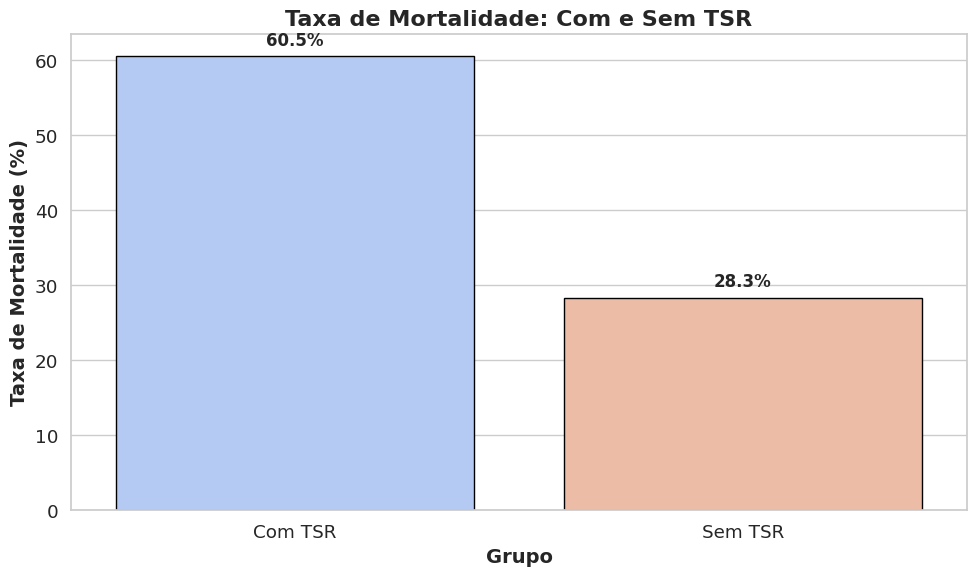

In [39]:
# 📥 Consulta SQL para obter dados de TSR e mortalidade
query_tsr_mortalidade = """
WITH tsr_status AS (
    SELECT 
        pm.subject_id,
        CASE 
            WHEN r.dialysis_present = 1 THEN 'Com TSR'
            ELSE 'Sem TSR'
        END AS grupo,
        COUNT(*) FILTER (WHERE r.dialysis_present = 1) AS n_tsr
    FROM pacientes_mortos pm
    LEFT JOIN mimiciv_derived.first_day_rrt r ON pm.stay_id = r.stay_id
    GROUP BY pm.subject_id, r.dialysis_present
),
mortalidade_tsr AS (
    SELECT 
        grupo,
        COUNT(*) AS total_pacientes,
        COUNT(CASE WHEN pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 1 END) AS total_mortes
    FROM tsr_status
    JOIN pacientes_mortos pm ON tsr_status.subject_id = pm.subject_id
    GROUP BY grupo
)
SELECT 
    grupo,
    total_pacientes,
    total_mortes,
    (total_mortes::float / total_pacientes) * 100 AS taxa_mortalidade
FROM mortalidade_tsr
ORDER BY grupo;
"""

# Carregar os resultados da consulta SQL em um DataFrame
df_tsr_mortalidade = pd.read_sql(query_tsr_mortalidade, conn)

# Exibir os resultados no console
print("\n📊 Quantidade de Pacientes com e sem TSR e suas Mortalidades:")
print(df_tsr_mortalidade)

# 📊 Criar o gráfico de barras
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid", font_scale=1.2)

# Gráfico de barras
sns.barplot(data=df_tsr_mortalidade, x="grupo", y="taxa_mortalidade", palette="coolwarm", edgecolor='black')

# Título e rótulos
plt.title("Taxa de Mortalidade: Com e Sem TSR", fontsize=16, fontweight='bold')
plt.xlabel("Grupo", fontsize=14, fontweight='bold')
plt.ylabel("Taxa de Mortalidade (%)", fontsize=14, fontweight='bold')

# Anotar as taxas de mortalidade nas barras
for i, taxa in enumerate(df_tsr_mortalidade['taxa_mortalidade']):
    plt.text(i, taxa + 1, f"{taxa:.1f}%", ha='center', va='bottom', fontsize=12, fontweight='bold')

# Melhorar espaçamento
plt.tight_layout()

# Mostrar o gráfico
plt.show()

/tmp/ipykernel_185560/432189603.py:31: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


   subject_id  sapsii  sapsii_prob  oasis  oasis_prob  sofa_24hours
0    10000032      38     0.212560     31    0.097783             2
1    10001843      69     0.826120     38    0.209226             5
2    10001884      44     0.326364     35    0.152892             4
3    10002114      43     0.305597     32    0.109623             9
4    10002155      90     0.966679     51    0.581248             7

Matriz de Correlação dos Indicadores Clínicos:
                sapsii     oasis  sofa_24hours
sapsii        1.000000  0.678905      0.536428
oasis         0.678905  1.000000      0.458545
sofa_24hours  0.536428  0.458545      1.000000


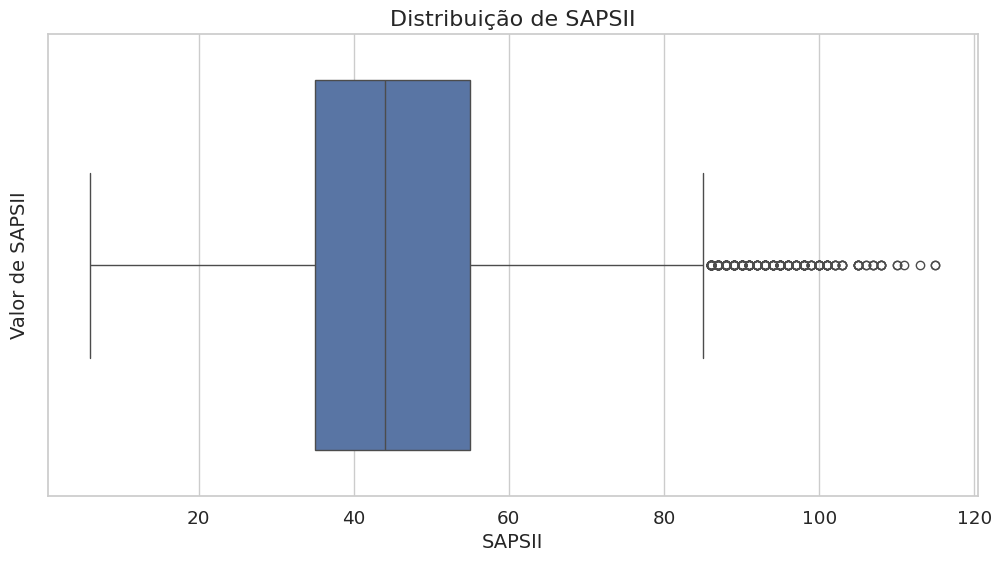

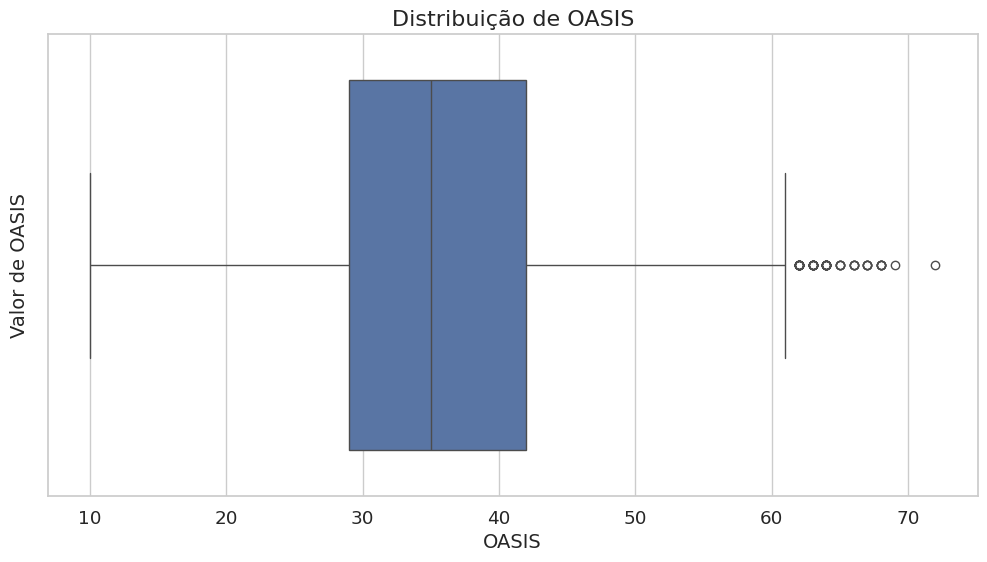

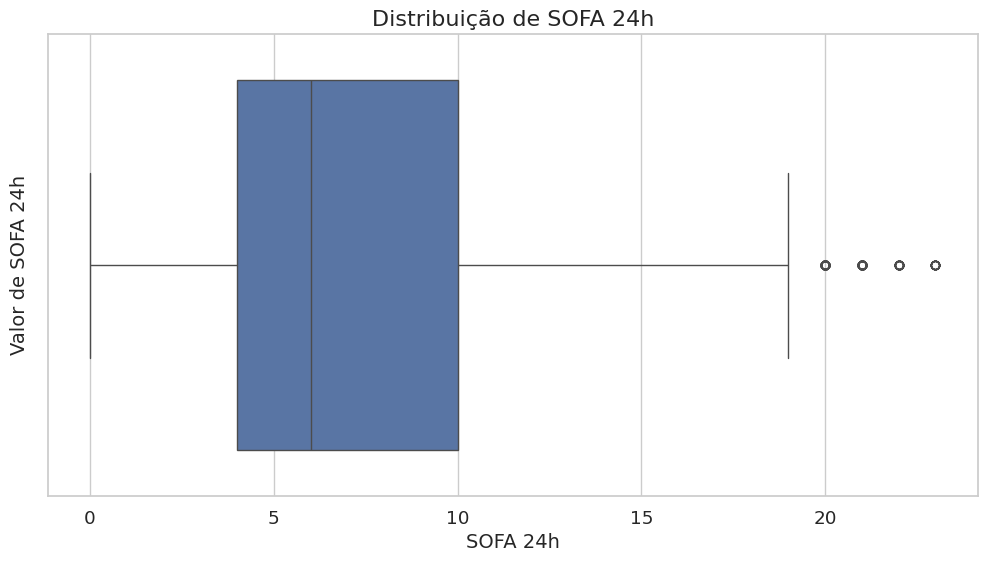

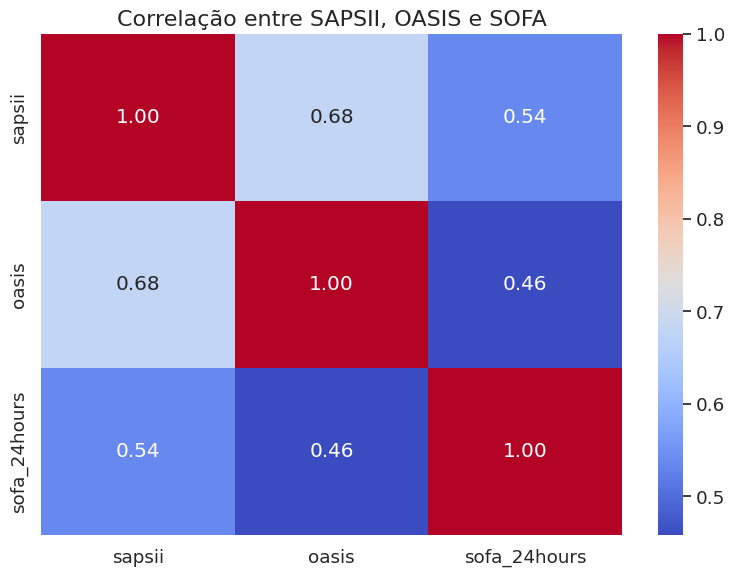

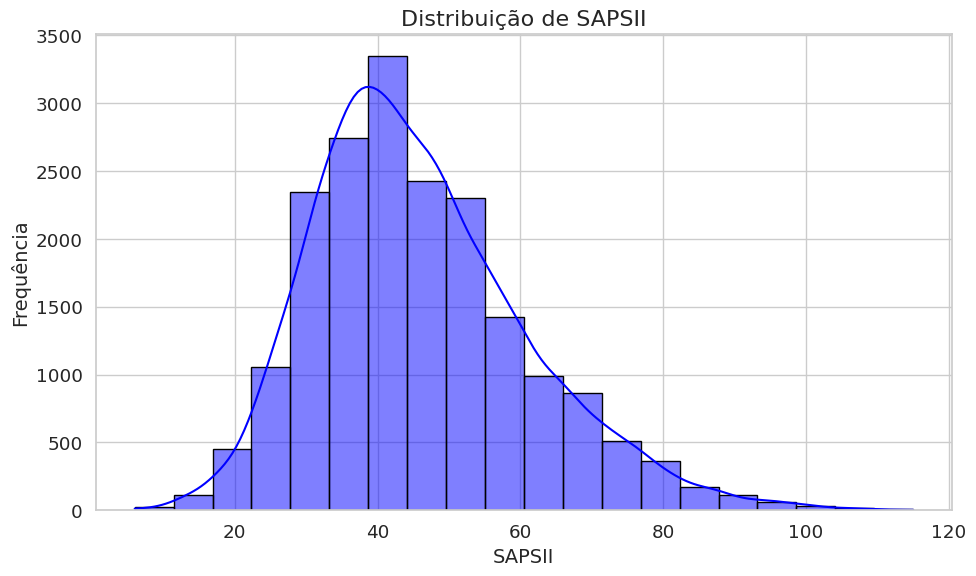

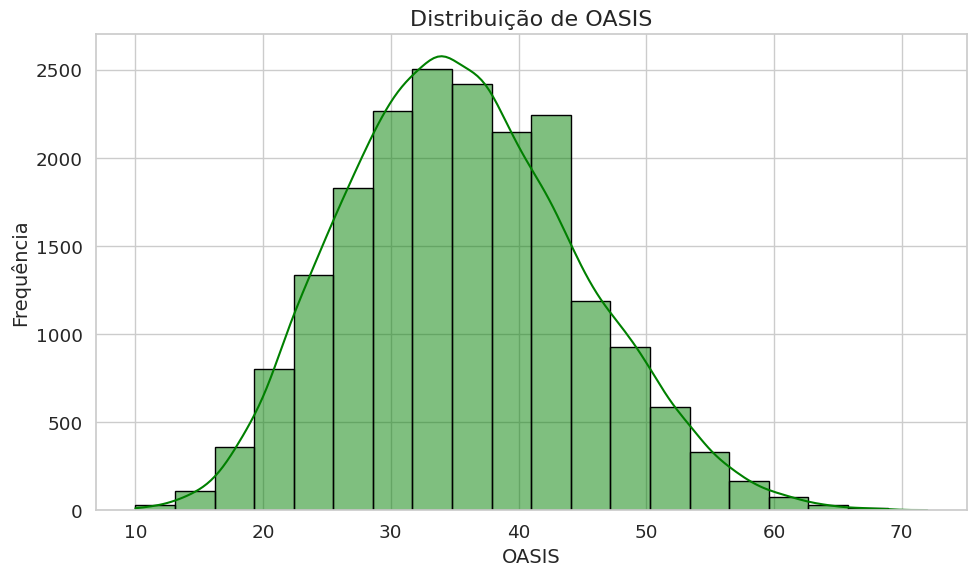

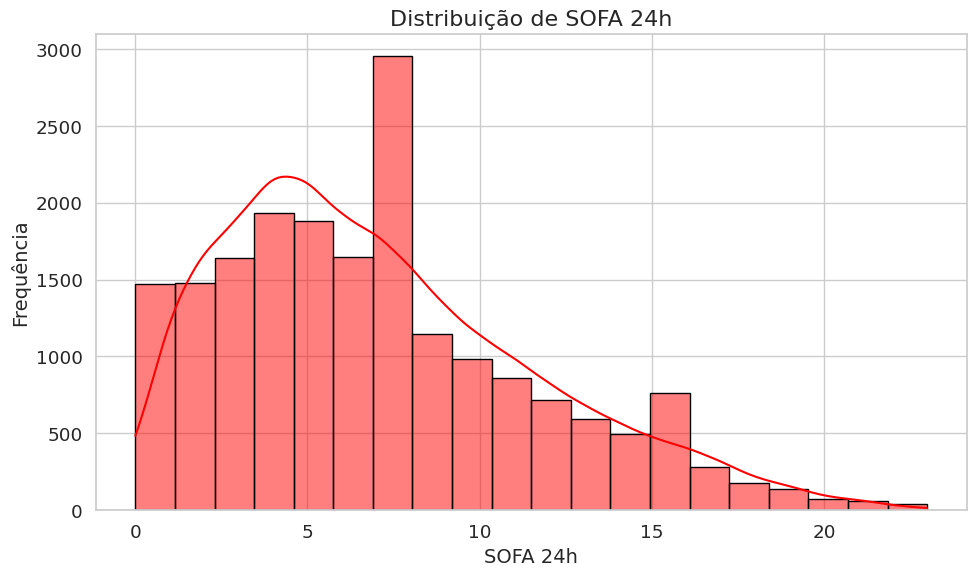

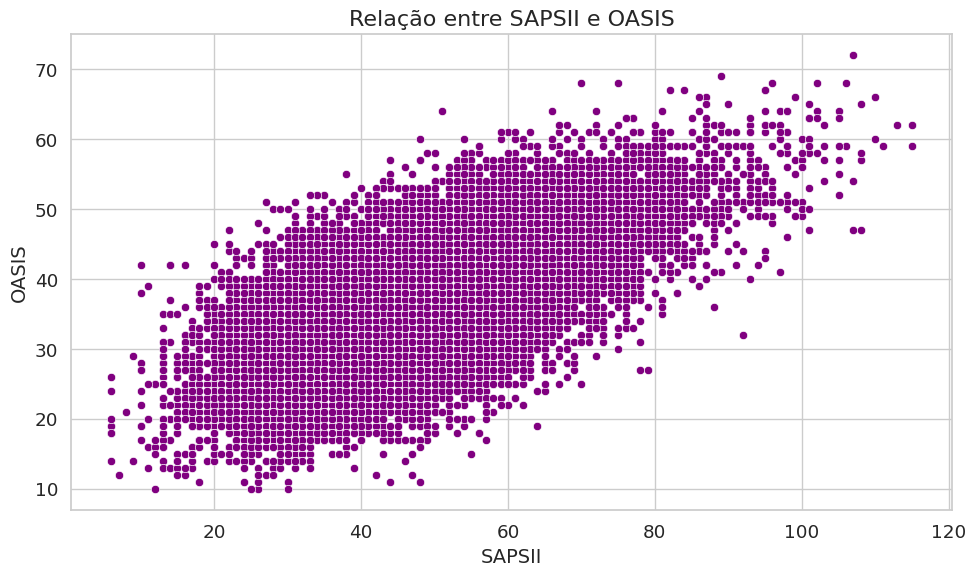

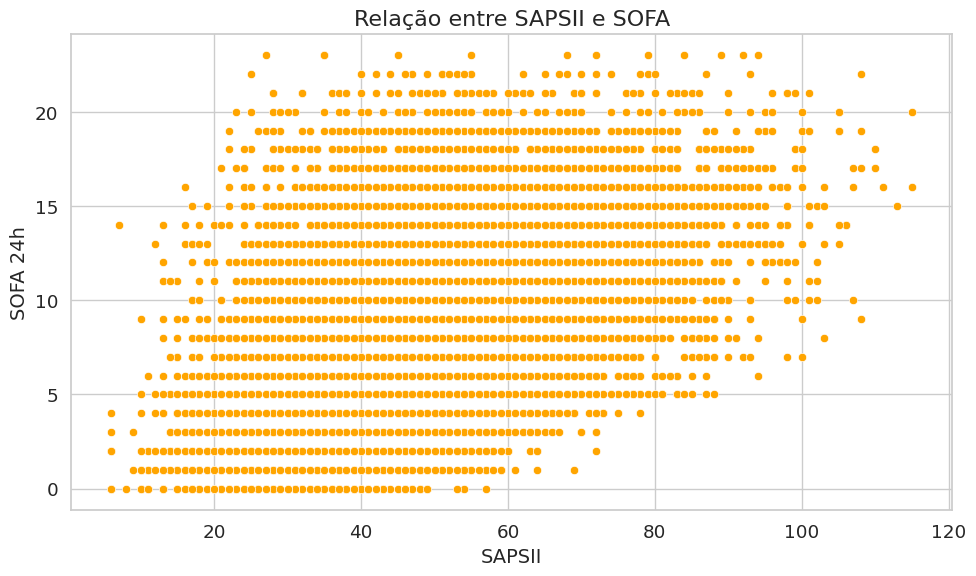

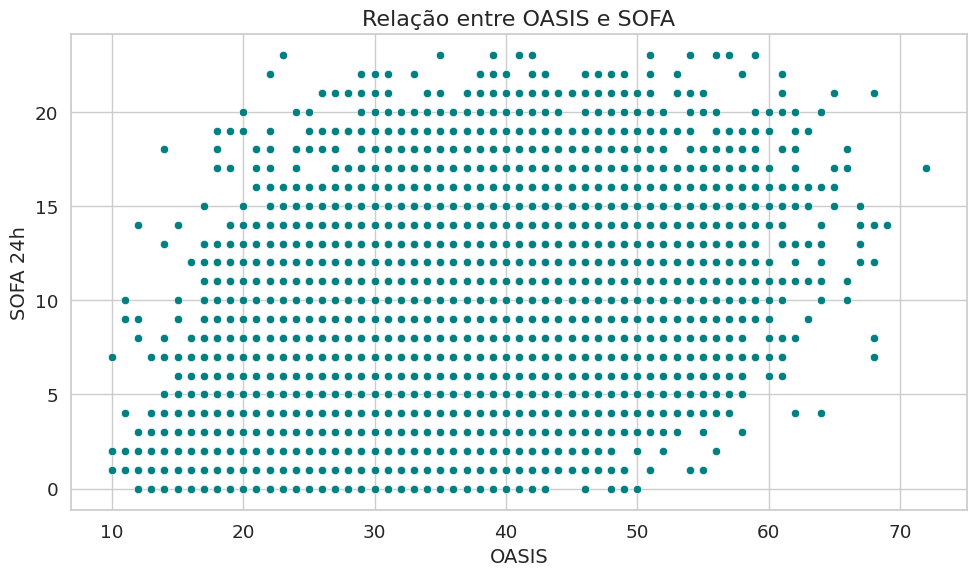

/tmp/ipykernel_185560/432189603.py:146: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=medias.index, y=medias.values, palette='viridis', edgecolor='black')


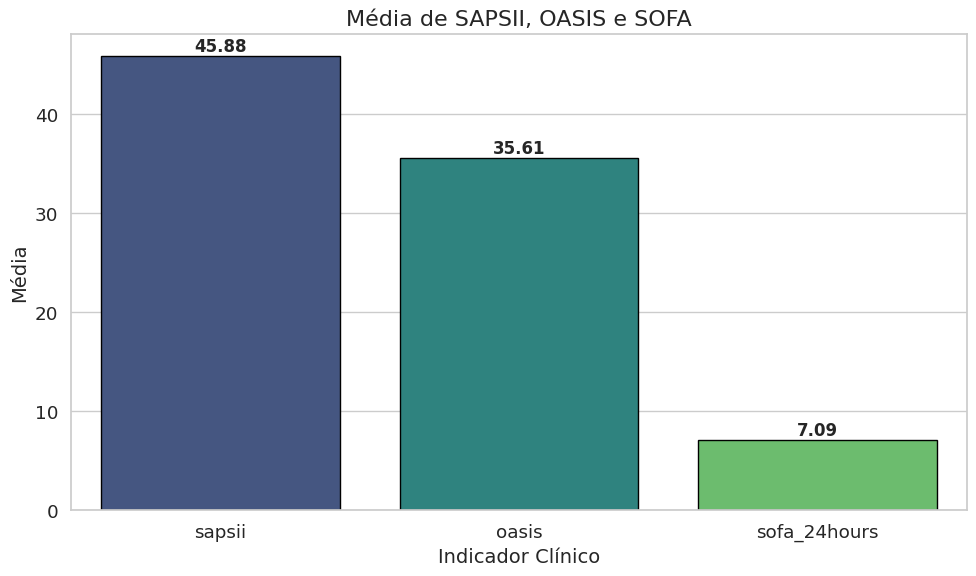

/tmp/ipykernel_185560/432189603.py:164: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Indicador', y='Valor', data=df_melted, palette='Set2')


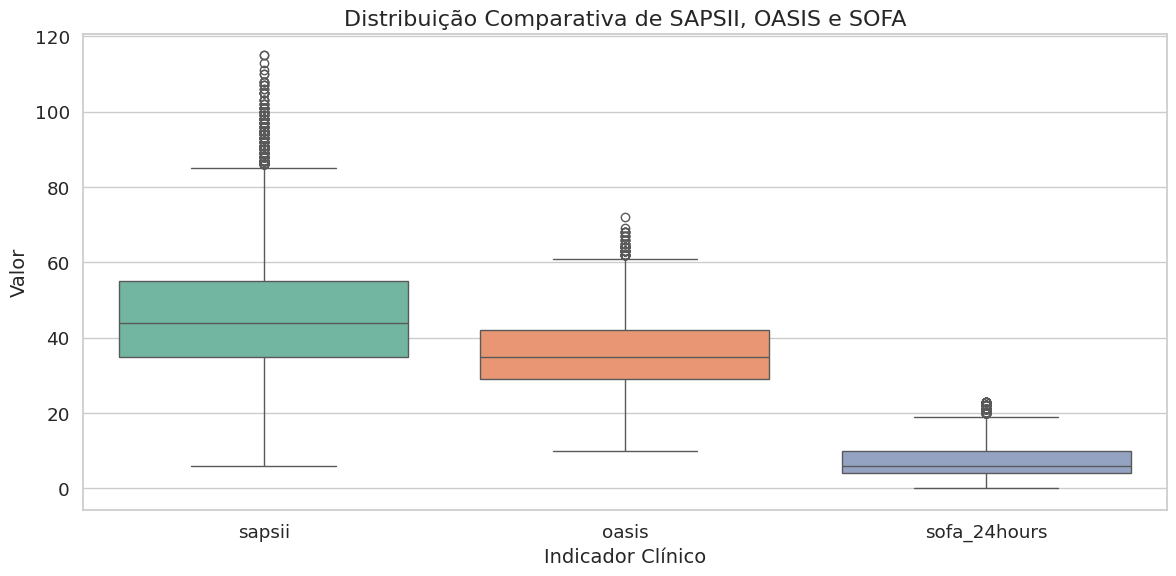

ValueError: Could not interpret value `charttime` for `x`. An entry with this name does not appear in `data`.

<Figure size 1200x600 with 0 Axes>

In [40]:
# 🔎 Query SQL para obter dados de SAPSII, OASIS, SOFA e Mortalidade
query = """
SELECT 
    p.subject_id,
    MAX(s.sapsii) AS sapsii,  -- Pega o maior valor de SAPSII
    MAX(s.sapsii_prob) AS sapsii_prob,  -- Pega o maior valor de probabilidade de SAPSII
    MAX(o.oasis) AS oasis,  -- Pega o maior valor de OASIS
    MAX(o.oasis_prob) AS oasis_prob,  -- Pega o maior valor de probabilidade de OASIS
    MAX(f.sofa_24hours) AS sofa_24hours,  -- Pega o maior valor de SOFA nas últimas 24h
    CASE WHEN MAX(pm.categoria) != 'Sobrevivente (≥ 1 ano pós-alta)' THEN 1 ELSE 0 END AS morreu  -- Mortalidade binária
FROM 
    mimiciv_icu.icustays p
JOIN
    mimiciv_derived.sapsii s ON p.stay_id = s.stay_id
JOIN
    mimiciv_derived.oasis o ON p.stay_id = o.stay_id
JOIN
    mimiciv_derived.sofa f ON p.stay_id = f.stay_id
JOIN
    pacientes_mortos pm ON p.stay_id = pm.stay_id
WHERE 
    pm.categoria != 'Sobrevivente (≥ 1 ano pós-alta)'  -- Considera apenas pacientes mortos
GROUP BY
    p.subject_id  -- Agrupar por paciente
ORDER BY
    p.subject_id;

"""

# Carregar o resultado da consulta SQL em um DataFrame
df = pd.read_sql(query, conn)

# Passo 1: Remover a coluna 'morreu' e pegar o maior valor de exame para cada paciente (evitar duplicação)
df_max = df.drop(columns=['morreu'])  # Remover a coluna 'morreu'
df_max = df_max.groupby('subject_id').agg({
    'sapsii': 'max',  # Pega o maior valor de SAPSII
    'sapsii_prob': 'max',  # Pega o maior valor de probabilidade de SAPSII
    'oasis': 'max',  # Pega o maior valor de OASIS
    'oasis_prob': 'max',  # Pega o maior valor de probabilidade de OASIS
    'sofa_24hours': 'max'  # Pega o maior valor de SOFA nas últimas 24h
}).reset_index()

# Exibir as primeiras linhas do DataFrame com os valores máximos
print(df_max.head())

# Passo 2: Análise de Correlação entre SAPSII, OASIS e SOFA
corr = df_max[['sapsii', 'oasis', 'sofa_24hours']].corr()

# Exibir a matriz de correlação
print("\nMatriz de Correlação dos Indicadores Clínicos:")
print(corr)

# Passo 3: Visualização - Boxplot para comparar distribuições de SAPSII, OASIS e SOFA entre os pacientes

# Boxplot para SAPSII
plt.figure(figsize=(12, 6))
sns.boxplot(x='sapsii', data=df_max)
plt.title("Distribuição de SAPSII", fontsize=16)
plt.xlabel("SAPSII", fontsize=14)
plt.ylabel("Valor de SAPSII", fontsize=14)
plt.show()

# Boxplot para OASIS
plt.figure(figsize=(12, 6))
sns.boxplot(x='oasis', data=df_max)
plt.title("Distribuição de OASIS", fontsize=16)
plt.xlabel("OASIS", fontsize=14)
plt.ylabel("Valor de OASIS", fontsize=14)
plt.show()

# Boxplot para SOFA
plt.figure(figsize=(12, 6))
sns.boxplot(x='sofa_24hours', data=df_max)
plt.title("Distribuição de SOFA 24h", fontsize=16)
plt.xlabel("SOFA 24h", fontsize=14)
plt.ylabel("Valor de SOFA 24h", fontsize=14)
plt.show()

# Passo 4: Heatmap de correlação entre SAPSII, OASIS e SOFA
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlação entre SAPSII, OASIS e SOFA", fontsize=16)
plt.tight_layout()
plt.show()


# Histograma para SAPSII
plt.figure(figsize=(10, 6))
sns.histplot(df_max['sapsii'], bins=20, kde=True, color='blue', edgecolor='black')
plt.title("Distribuição de SAPSII", fontsize=16)
plt.xlabel("SAPSII", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.tight_layout()
plt.show()

# Histograma para OASIS
plt.figure(figsize=(10, 6))
sns.histplot(df_max['oasis'], bins=20, kde=True, color='green', edgecolor='black')
plt.title("Distribuição de OASIS", fontsize=16)
plt.xlabel("OASIS", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.tight_layout()
plt.show()

# Histograma para SOFA
plt.figure(figsize=(10, 6))
sns.histplot(df_max['sofa_24hours'], bins=20, kde=True, color='red', edgecolor='black')
plt.title("Distribuição de SOFA 24h", fontsize=16)
plt.xlabel("SOFA 24h", fontsize=14)
plt.ylabel("Frequência", fontsize=14)
plt.tight_layout()
plt.show()

# Scatter plot entre SAPSII e OASIS
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sapsii', y='oasis', data=df_max, color='purple')
plt.title("Relação entre SAPSII e OASIS", fontsize=16)
plt.xlabel("SAPSII", fontsize=14)
plt.ylabel("OASIS", fontsize=14)
plt.tight_layout()
plt.show()

# Scatter plot entre SAPSII e SOFA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='sapsii', y='sofa_24hours', data=df_max, color='orange')
plt.title("Relação entre SAPSII e SOFA", fontsize=16)
plt.xlabel("SAPSII", fontsize=14)
plt.ylabel("SOFA 24h", fontsize=14)
plt.tight_layout()
plt.show()

# Scatter plot entre OASIS e SOFA
plt.figure(figsize=(10, 6))
sns.scatterplot(x='oasis', y='sofa_24hours', data=df_max, color='teal')
plt.title("Relação entre OASIS e SOFA", fontsize=16)
plt.xlabel("OASIS", fontsize=14)
plt.ylabel("SOFA 24h", fontsize=14)
plt.tight_layout()
plt.show()

# Calcular as médias
medias = df_max[['sapsii', 'oasis', 'sofa_24hours']].mean()

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x=medias.index, y=medias.values, palette='viridis', edgecolor='black')
plt.title("Média de SAPSII, OASIS e SOFA", fontsize=16)
plt.xlabel("Indicador Clínico", fontsize=14)
plt.ylabel("Média", fontsize=14)

# Adicionar valores nas barras
for i, v in enumerate(medias.values):
    plt.text(i, v + 0.5, f"{v:.2f}", ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Preparar os dados para o boxplot comparativo
df_melted = df_max.melt(id_vars=['subject_id'], value_vars=['sapsii', 'oasis', 'sofa_24hours'],
                        var_name='Indicador', value_name='Valor')

# Boxplot comparativo
plt.figure(figsize=(12, 6))
sns.boxplot(x='Indicador', y='Valor', data=df_melted, palette='Set2')
plt.title("Distribuição Comparativa de SAPSII, OASIS e SOFA", fontsize=16)
plt.xlabel("Indicador Clínico", fontsize=14)
plt.ylabel("Valor", fontsize=14)
plt.tight_layout()
plt.show()

# Exemplo de gráfico de linhas (se houver dados temporais)
# Aqui, assumimos que há uma coluna 'charttime' no DataFrame original
# df['charttime'] = pd.to_datetime(df['charttime'])  # Certifique-se de que charttime está no formato datetime

# Gráfico de linhas para SAPSII ao longo do tempo
plt.figure(figsize=(12, 6))
sns.lineplot(x='charttime', y='sapsii', data=df, label='SAPSII', color='blue')
sns.lineplot(x='charttime', y='oasis', data=df, label='OASIS', color='green')
sns.lineplot(x='charttime', y='sofa_24hours', data=df, label='SOFA', color='red')
plt.title("Tendência de SAPSII, OASIS e SOFA ao Longo do Tempo", fontsize=16)
plt.xlabel("Tempo", fontsize=14)
plt.ylabel("Valor", fontsize=14)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Definir a consulta SQL otimizada
query = """
WITH exames_filtrados AS (
    SELECT
        e.subject_id,
        e.valuenum,
        e.charttime,
        ROW_NUMBER() OVER (PARTITION BY e.subject_id ORDER BY e.charttime DESC) AS rn
    FROM mimiciv_icu.chartevents e
    JOIN pacientes_mortos pm ON e.stay_id = pm.stay_id
    WHERE e.valuenum IS NOT NULL
),
estatisticas_exames AS (
    SELECT 
        subject_id,
        AVG(valuenum) AS media,
        VARIANCE(valuenum) AS variancia
    FROM exames_filtrados
    GROUP BY subject_id
),
ultimo_exame AS (
    SELECT 
        subject_id,
        valuenum AS ultimo_valor
    FROM exames_filtrados
    WHERE rn = 1
)
SELECT 
    e.subject_id,
    e.media,
    e.variancia,
    u.ultimo_valor
FROM estatisticas_exames e
JOIN ultimo_exame u ON e.subject_id = u.subject_id
"""

# Carregar o resultado da consulta SQL
#df = pd.read_sql(query, conn)

# Exibir as primeiras linhas do DataFrame com as estatísticas calculadas
#print(df.head())

In [ ]:
import pandas as pd

# Query SQL para extrair subject_id e target binário
query = """
SELECT
  subject_id,
  CASE 
    WHEN categoria = 'Sobrevivente (≥ 1 ano pós-alta)' THEN 0
    ELSE 1
  END AS target
FROM pacientes_mortos;
"""

# Executar a query e carregar no DataFrame
#df_modelagem_minima = pd.read_sql(query, conn)

# Salvar o DataFrame como CSV
#df_modelagem_minima.to_csv("dataset_modelagem_minimo.csv", index=False)

#print("📁 Arquivo salvo como: dataset_modelagem_minimo.csv")

